In [1]:
# plot sections monthly:

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import iris
import iris.iterate
import iris.coords
import iris.plot as iplt
import gsw

In [2]:
# load ROMS avg output
ds = xr.open_dataset("/Volumes/Seagate-4Tb/WAOM_runs/waom10_shflim_S_ORAS5em_0.25Q/output_01-20yr/ocean_avg_0002.nc")
#print(output.variables.keys()) # get all variable names

temp = ds.variables["temp"]
salt = ds.variables["salt"]

dens=gsw.rho(salt,temp,2000)
        # Substract 1000 to convert to sigma-t
dens = dens - 1000
print(temp.shape,dens.shape)
m_len = temp[:,0,0,0].size
k_len = temp[0,:,0,0].size
i_len = temp[0,0,:,0].size
j_len = temp[0,0,0,:].size

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

if ds.Vtransform == 1:
    Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
    z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
    print("Vtransform=1")
elif ds.Vtransform == 2:
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
    print("Vtransform=2")
ds.coords['z_rho'] = z_rho.transpose() # put z_rho into ds dataset

dg = xr.open_dataset("/Volumes/Seagate-4Tb/WAOM_runs/waom10_frc/waom10_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset



(12, 31, 530, 630) (12, 31, 530, 630)
Vtransform=2


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.


In [3]:
# Weddell Sea
# 1 - slice section for salt/temp/z_rho
section_salt_wed = np.empty((12,31,170)) # allocating
section_temp_wed = np.empty((12,31,170))
section_rho_wed = np.empty((12,31,170))
section_z_wed = np.empty((12,31,170))
section_z_wed_mask = np.empty((12,31,170))
for mm in np.arange(0,12):
    section_salt_wed[mm,:,:] = ds.salt.isel(xi_rho=170, eta_rho=slice(280,450), ocean_time=mm)
    section_temp_wed[mm,:,:] = ds.temp.isel(xi_rho=170, eta_rho=slice(280,450), ocean_time=mm)
    section_z_wed[mm,:,:] = ds.z_rho.isel(xi_rho=170, eta_rho=slice(280,450), ocean_time=mm)
    # 1.1 - mask land values in z_rho slice                                           
    section_z_wed_mask[mm,:,:] = ma.array(section_z_wed[mm,:,:],mask=np.isnan(section_z_wed[mm,:,:]))
    section_rho_wed[mm,:,:] = np.squeeze(dens[mm,:,280:450,200])
    
# 2 - slide section for lon or lat
section_lat_wed_tmp = ds.lat_rho.isel(xi_rho=170, eta_rho=slice(280,450))
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_wed = np.ones((31,170))                                                
for ii in np.arange(0,31):
    section_lat_wed[ii,:] = section_lat_wed_tmp
section_lat_wed_mask = ma.array(section_lat_wed,mask=np.isnan(section_z_wed[0,:,:]))

print(section_lat_wed.shape, section_z_wed.shape, section_salt_wed.shape)

## season averages:
section_z_wed_mask_JFM = np.squeeze(np.nanmean(section_z_wed_mask[0:2,:,:], axis=0))
section_z_wed_mask_AMJ = np.squeeze(np.nanmean(section_z_wed_mask[3:5,:,:], axis=0))
section_z_wed_mask_JAS = np.squeeze(np.nanmean(section_z_wed_mask[6:8,:,:], axis=0))
section_z_wed_mask_OND = np.squeeze(np.nanmean(section_z_wed_mask[9:11,:,:], axis=0))

section_temp_wed_JFM = np.squeeze(np.nanmean(section_temp_wed[0:2,:,:], axis=0))
section_temp_wed_AMJ = np.squeeze(np.nanmean(section_temp_wed[3:5,:,:], axis=0))
section_temp_wed_JAS = np.squeeze(np.nanmean(section_temp_wed[6:8,:,:], axis=0))
section_temp_wed_OND = np.squeeze(np.nanmean(section_temp_wed[9:11,:,:], axis=0))

section_salt_wed_JFM = np.squeeze(np.nanmean(section_salt_wed[0:2,:,:], axis=0))
section_salt_wed_AMJ = np.squeeze(np.nanmean(section_salt_wed[3:5,:,:], axis=0))
section_salt_wed_JAS = np.squeeze(np.nanmean(section_salt_wed[6:8,:,:], axis=0))
section_salt_wed_OND = np.squeeze(np.nanmean(section_salt_wed[9:11,:,:], axis=0))

section_rho_wed_JFM = np.squeeze(np.nanmean(section_rho_wed[0:2,:,:], axis=0))
section_rho_wed_AMJ = np.squeeze(np.nanmean(section_rho_wed[3:5,:,:], axis=0))
section_rho_wed_JAS = np.squeeze(np.nanmean(section_rho_wed[6:8,:,:], axis=0))
section_rho_wed_OND = np.squeeze(np.nanmean(section_rho_wed[9:11,:,:], axis=0))

section_z_wed_mask_ann = np.squeeze(np.nanmean(section_z_wed_mask[:,:,:], axis=0))
section_temp_wed_ann = np.squeeze(np.nanmean(section_temp_wed[:,:,:], axis=0))
section_salt_wed_ann = np.squeeze(np.nanmean(section_salt_wed[:,:,:], axis=0))
section_rho_wed_ann = np.squeeze(np.nanmean(section_rho_wed[:,:,:], axis=0))

print(section_lat_wed.shape, section_z_wed_mask_JFM.shape, section_salt_wed_JFM.shape)

(31, 170) (12, 31, 170) (12, 31, 170)
(31, 170) (31, 170) (31, 170)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ip

In [4]:
# Ross Sea
# 1 - slice section for salt/temp/z_rho
section_salt_ros = np.empty((12,31,230)) # allocating
section_temp_ros = np.empty((12,31,230))
section_rho_ros = np.empty((12,31,230))
section_z_ros = np.empty((12,31,230))
section_z_ros_mask = np.empty((12,31,230))
for mm in np.arange(0,12):
    section_salt_ros[mm,:,:] = ds.salt.isel(xi_rho=310, eta_rho=slice(20,250), ocean_time=mm)
    section_temp_ros[mm,:,:] = ds.temp.isel(xi_rho=310, eta_rho=slice(20,250), ocean_time=mm)
    section_z_ros[mm,:,:] = ds.z_rho.isel(xi_rho=310, eta_rho=slice(20,250), ocean_time=mm)
    # 1.1 - mask land values in z_rho slice                                           
    section_z_ros_mask[...] = ma.array(section_z_ros[mm,:,:],mask=np.isnan(section_z_ros[mm,:,:]))
    section_rho_ros[mm,:,:] = np.squeeze(dens[mm,:,20:250,310])

# 2 - slide section for lon or lat
section_lat_ros_tmp = ds.lat_rho.isel(xi_rho=310, eta_rho=slice(20,250))
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_ros = np.ones((31,230))                                                
for ii in np.arange(0,31):
    section_lat_ros[ii,:] = section_lat_ros_tmp
section_lat_ros_mask = ma.array(section_lat_ros,mask=np.isnan(section_z_ros[0,:,:]))

print(section_lat_ros.shape, section_z_ros.shape, section_salt_ros.shape)

## season averages:
section_z_ros_mask_JFM = np.squeeze(np.nanmean(section_z_ros_mask[0:2,:,:], axis=0))
section_z_ros_mask_AMJ = np.squeeze(np.nanmean(section_z_ros_mask[3:5,:,:], axis=0))
section_z_ros_mask_JAS = np.squeeze(np.nanmean(section_z_ros_mask[6:8,:,:], axis=0))
section_z_ros_mask_OND = np.squeeze(np.nanmean(section_z_ros_mask[9:11,:,:], axis=0))

section_temp_ros_JFM = np.squeeze(np.nanmean(section_temp_ros[0:2,:,:], axis=0))
section_temp_ros_AMJ = np.squeeze(np.nanmean(section_temp_ros[3:5,:,:], axis=0))
section_temp_ros_JAS = np.squeeze(np.nanmean(section_temp_ros[6:8,:,:], axis=0))
section_temp_ros_OND = np.squeeze(np.nanmean(section_temp_ros[9:11,:,:], axis=0))

section_salt_ros_JFM = np.squeeze(np.nanmean(section_salt_ros[0:2,:,:], axis=0))
section_salt_ros_AMJ = np.squeeze(np.nanmean(section_salt_ros[3:5,:,:], axis=0))
section_salt_ros_JAS = np.squeeze(np.nanmean(section_salt_ros[6:8,:,:], axis=0))
section_salt_ros_OND = np.squeeze(np.nanmean(section_salt_ros[9:11,:,:], axis=0))

section_rho_ros_JFM = np.squeeze(np.nanmean(section_rho_ros[0:2,:,:], axis=0))
section_rho_ros_AMJ = np.squeeze(np.nanmean(section_rho_ros[3:5,:,:], axis=0))
section_rho_ros_JAS = np.squeeze(np.nanmean(section_rho_ros[6:8,:,:], axis=0))
section_rho_ros_OND = np.squeeze(np.nanmean(section_rho_ros[9:11,:,:], axis=0))

section_z_ros_mask_ann = np.squeeze(np.nanmean(section_z_ros_mask[:,:,:], axis=0))
section_temp_ros_ann = np.squeeze(np.nanmean(section_temp_ros[:,:,:], axis=0))
section_salt_ros_ann = np.squeeze(np.nanmean(section_salt_ros[:,:,:], axis=0))
section_rho_ros_ann = np.squeeze(np.nanmean(section_rho_ros[:,:,:], axis=0))

print(section_lat_ros.shape, section_z_ros_mask_JFM.shape, section_salt_ros_JFM.shape)

(31, 230) (12, 31, 230) (12, 31, 230)
(31, 230) (31, 230) (31, 230)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ip

In [5]:
# Prydz Bay
# 1 - slice section for salt/temp/z_rho
section_salt_pry = np.empty((12,31,180)) # allocating
section_temp_pry = np.empty((12,31,180))
section_rho_pry = np.empty((12,31,180))
section_z_pry = np.empty((12,31,180))
section_z_pry_mask = np.empty((12,31,180))
for mm in np.arange(0,12):
    section_salt_pry[mm,:,:] = ds.salt.isel(xi_rho=slice(420,600), eta_rho=338, ocean_time=mm)
    section_temp_pry[mm,:,:] = ds.temp.isel(xi_rho=slice(420,600), eta_rho=338, ocean_time=mm)
    section_z_pry[mm,:,:] = ds.z_rho.isel(xi_rho=slice(420,600), eta_rho=338, ocean_time=mm)
    # 1.1 - mask land values in z_rho slice                                           
    section_z_pry_mask[...] = ma.array(section_z_pry[mm,:,:],mask=np.isnan(section_z_pry[mm,:,:]))
    section_rho_pry[mm,:,:] = np.squeeze(dens[mm,:,338,420:600])

# 2 - slide section for lon or lat
section_lon_pry_tmp = ds.lon_rho.isel(xi_rho=slice(420,600), eta_rho=338)
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lon_pry = np.ones((31,180))                                                
for ii in np.arange(0,31):
    section_lon_pry[ii,:] = section_lon_pry_tmp
section_lon_pry_mask = ma.array(section_lon_pry,mask=np.isnan(section_z_pry[0,:,:]))

print(section_lon_pry.shape, section_z_pry.shape, section_salt_pry.shape)

## season averages:
section_z_pry_mask_JFM = np.squeeze(np.nanmean(section_z_pry_mask[0:2,:,:], axis=0))
section_z_pry_mask_AMJ = np.squeeze(np.nanmean(section_z_pry_mask[3:5,:,:], axis=0))
section_z_pry_mask_JAS = np.squeeze(np.nanmean(section_z_pry_mask[6:8,:,:], axis=0))
section_z_pry_mask_OND = np.squeeze(np.nanmean(section_z_pry_mask[9:11,:,:], axis=0))

section_temp_pry_JFM = np.squeeze(np.nanmean(section_temp_pry[0:2,:,:], axis=0))
section_temp_pry_AMJ = np.squeeze(np.nanmean(section_temp_pry[3:5,:,:], axis=0))
section_temp_pry_JAS = np.squeeze(np.nanmean(section_temp_pry[6:8,:,:], axis=0))
section_temp_pry_OND = np.squeeze(np.nanmean(section_temp_pry[9:11,:,:], axis=0))

section_salt_pry_JFM = np.squeeze(np.nanmean(section_salt_pry[0:2,:,:], axis=0))
section_salt_pry_AMJ = np.squeeze(np.nanmean(section_salt_pry[3:5,:,:], axis=0))
section_salt_pry_JAS = np.squeeze(np.nanmean(section_salt_pry[6:8,:,:], axis=0))
section_salt_pry_OND = np.squeeze(np.nanmean(section_salt_pry[9:11,:,:], axis=0))

section_rho_pry_JFM = np.squeeze(np.nanmean(section_rho_pry[0:2,:,:], axis=0))
section_rho_pry_AMJ = np.squeeze(np.nanmean(section_rho_pry[3:5,:,:], axis=0))
section_rho_pry_JAS = np.squeeze(np.nanmean(section_rho_pry[6:8,:,:], axis=0))
section_rho_pry_OND = np.squeeze(np.nanmean(section_rho_pry[9:11,:,:], axis=0))

section_z_pry_mask_ann = np.squeeze(np.nanmean(section_z_pry_mask[:,:,:], axis=0))
section_temp_pry_ann = np.squeeze(np.nanmean(section_temp_pry[:,:,:], axis=0))
section_salt_pry_ann = np.squeeze(np.nanmean(section_salt_pry[:,:,:], axis=0))
section_rho_pry_ann = np.squeeze(np.nanmean(section_rho_pry[:,:,:], axis=0))

print(section_lon_pry.shape, section_z_pry_mask_JFM.shape, section_salt_pry_JFM.shape)

(31, 180) (12, 31, 180) (12, 31, 180)
(31, 180) (31, 180) (31, 180)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ip

In [6]:
# Maud Land 1:
# 1 - slice section for salt/temp/z_rho
section_salt_neu = np.empty((12,31,100)) # allocating
section_temp_neu = np.empty((12,31,100))
section_rho_neu = np.empty((12,31,100))
section_z_neu = np.empty((12,31,100))
section_z_neu_mask = np.empty((12,31,100))
for mm in np.arange(0,12):
    section_salt_neu[mm,:,:] = ds.salt.isel(xi_rho=280, eta_rho=slice(420,520), ocean_time=mm)
    section_temp_neu[mm,:,:] = ds.temp.isel(xi_rho=280, eta_rho=slice(420,520), ocean_time=mm)
    section_z_neu[mm,:,:] = ds.z_rho.isel(xi_rho=280, eta_rho=slice(420,520), ocean_time=mm)
    # 1.1 - mask land values in z_rho slice                                           
    section_z_neu_mask[mm,:,:] = ma.array(section_z_neu[mm,:,:],mask=np.isnan(section_z_neu[mm,:,:]))
    section_rho_neu[mm,:,:] = np.squeeze(dens[mm,:,420:520,280])

# 2 - slide section for lon or lat
section_lat_neu_tmp = ds.lat_rho.isel(xi_rho=280, eta_rho=slice(420,520))
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_neu = np.ones((31,100))                                                
for ii in np.arange(0,31):
    section_lat_neu[ii,:] = section_lat_neu_tmp
section_lat_neu_mask = ma.array(section_lat_neu,mask=np.isnan(section_z_neu[0,:,:]))

print(section_lat_neu.shape, section_z_neu.shape, section_salt_neu.shape)

## season averages:
section_z_neu_mask_JFM = np.squeeze(np.nanmean(section_z_neu_mask[0:2,:,:], axis=0))
section_z_neu_mask_AMJ = np.squeeze(np.nanmean(section_z_neu_mask[3:5,:,:], axis=0))
section_z_neu_mask_JAS = np.squeeze(np.nanmean(section_z_neu_mask[6:8,:,:], axis=0))
section_z_neu_mask_OND = np.squeeze(np.nanmean(section_z_neu_mask[9:11,:,:], axis=0))

section_temp_neu_JFM = np.squeeze(np.nanmean(section_temp_neu[0:2,:,:], axis=0))
section_temp_neu_AMJ = np.squeeze(np.nanmean(section_temp_neu[3:5,:,:], axis=0))
section_temp_neu_JAS = np.squeeze(np.nanmean(section_temp_neu[6:8,:,:], axis=0))
section_temp_neu_OND = np.squeeze(np.nanmean(section_temp_neu[9:11,:,:], axis=0))

section_salt_neu_JFM = np.squeeze(np.nanmean(section_salt_neu[0:2,:,:], axis=0))
section_salt_neu_AMJ = np.squeeze(np.nanmean(section_salt_neu[3:5,:,:], axis=0))
section_salt_neu_JAS = np.squeeze(np.nanmean(section_salt_neu[6:8,:,:], axis=0))
section_salt_neu_OND = np.squeeze(np.nanmean(section_salt_neu[9:11,:,:], axis=0))

section_rho_neu_JFM = np.squeeze(np.nanmean(section_rho_neu[0:2,:,:], axis=0))
section_rho_neu_AMJ = np.squeeze(np.nanmean(section_rho_neu[3:5,:,:], axis=0))
section_rho_neu_JAS = np.squeeze(np.nanmean(section_rho_neu[6:8,:,:], axis=0))
section_rho_neu_OND = np.squeeze(np.nanmean(section_rho_neu[9:11,:,:], axis=0))

section_z_neu_mask_ann = np.squeeze(np.nanmean(section_z_neu_mask[:,:,:], axis=0))
section_temp_neu_ann = np.squeeze(np.nanmean(section_temp_neu[:,:,:], axis=0))
section_salt_neu_ann = np.squeeze(np.nanmean(section_salt_neu[:,:,:], axis=0))
section_rho_neu_ann = np.squeeze(np.nanmean(section_rho_neu[:,:,:], axis=0))

print(section_lat_neu.shape, section_z_neu_mask_JFM.shape, section_salt_neu_JFM.shape)

(31, 100) (12, 31, 100) (12, 31, 100)
(31, 100) (31, 100) (31, 100)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ip

In [7]:
# Maud Land 2:
# 1 - slice section for salt/temp/z_rho
section_salt_mai = np.empty((12,31,100)) # allocating
section_temp_mai = np.empty((12,31,100))
section_rho_mai = np.empty((12,31,100))
section_z_mai = np.empty((12,31,100))
section_z_mai_mask = np.empty((12,31,100))
for mm in np.arange(0,12):
    section_salt_mai[mm,:,:] = ds.salt.isel(xi_rho=320, eta_rho=slice(420,520), ocean_time=mm)
    section_temp_mai[mm,:,:] = ds.temp.isel(xi_rho=320, eta_rho=slice(420,520), ocean_time=mm)
    section_z_mai[mm,:,:] = ds.z_rho.isel(xi_rho=320, eta_rho=slice(420,520), ocean_time=mm)
    # 1.1 - mask land values in z_rho slice                                           
    section_z_mai_mask[mm,:,:] = ma.array(section_z_mai[mm,:,:],mask=np.isnan(section_z_mai[mm,:,:]))
    section_rho_mai[mm,:,:] = np.squeeze(dens[mm,:,420:520,320])
    
# 2 - slide section for lon or lat
section_lat_mai_tmp = ds.lat_rho.isel(xi_rho=320, eta_rho=slice(420,520))
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_mai = np.ones((31,100))                                                
for ii in np.arange(0,31):
    section_lat_mai[ii,:] = section_lat_mai_tmp
section_lat_mai_mask = ma.array(section_lat_mai,mask=np.isnan(section_z_mai[0,:,:]))

print(section_lat_mai.shape, section_z_mai.shape, section_salt_mai.shape)

## season averages:
section_z_mai_mask_JFM = np.squeeze(np.nanmean(section_z_mai_mask[0:2,:,:], axis=0))
section_z_mai_mask_AMJ = np.squeeze(np.nanmean(section_z_mai_mask[3:5,:,:], axis=0))
section_z_mai_mask_JAS = np.squeeze(np.nanmean(section_z_mai_mask[6:8,:,:], axis=0))
section_z_mai_mask_OND = np.squeeze(np.nanmean(section_z_mai_mask[9:11,:,:], axis=0))

section_temp_mai_JFM = np.squeeze(np.nanmean(section_temp_mai[0:2,:,:], axis=0))
section_temp_mai_AMJ = np.squeeze(np.nanmean(section_temp_mai[3:5,:,:], axis=0))
section_temp_mai_JAS = np.squeeze(np.nanmean(section_temp_mai[6:8,:,:], axis=0))
section_temp_mai_OND = np.squeeze(np.nanmean(section_temp_mai[9:11,:,:], axis=0))

section_salt_mai_JFM = np.squeeze(np.nanmean(section_salt_mai[0:2,:,:], axis=0))
section_salt_mai_AMJ = np.squeeze(np.nanmean(section_salt_mai[3:5,:,:], axis=0))
section_salt_mai_JAS = np.squeeze(np.nanmean(section_salt_mai[6:8,:,:], axis=0))
section_salt_mai_OND = np.squeeze(np.nanmean(section_salt_mai[9:11,:,:], axis=0))

section_rho_mai_JFM = np.squeeze(np.nanmean(section_rho_mai[0:2,:,:], axis=0))
section_rho_mai_AMJ = np.squeeze(np.nanmean(section_rho_mai[3:5,:,:], axis=0))
section_rho_mai_JAS = np.squeeze(np.nanmean(section_rho_mai[6:8,:,:], axis=0))
section_rho_mai_OND = np.squeeze(np.nanmean(section_rho_mai[9:11,:,:], axis=0))

section_z_mai_mask_ann = np.squeeze(np.nanmean(section_z_mai_mask[:,:,:], axis=0))
section_temp_mai_ann = np.squeeze(np.nanmean(section_temp_mai[:,:,:], axis=0))
section_salt_mai_ann = np.squeeze(np.nanmean(section_salt_mai[:,:,:], axis=0))
section_rho_mai_ann = np.squeeze(np.nanmean(section_rho_mai[:,:,:], axis=0))

print(section_lat_mai.shape, section_z_mai_mask_JFM.shape, section_salt_mai_JFM.shape)

(31, 100) (12, 31, 100) (12, 31, 100)
(31, 100) (31, 100) (31, 100)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ip

In [8]:
# Darnley Polynya
# 1 - slice section for salt/temp/z_rho
section_salt_dar = np.empty((12,31,155)) # allocating
section_temp_dar = np.empty((12,31,155))
section_rho_dar = np.empty((12,31,155))
section_z_dar = np.empty((12,31,155))
section_z_dar_mask = np.empty((12,31,155))
for mm in np.arange(0,12):
    section_salt_dar[mm,:,:] = ds.salt.isel(xi_rho=slice(460,615), eta_rho=350, ocean_time=mm)
    section_temp_dar[mm,:,:] = ds.temp.isel(xi_rho=slice(460,615), eta_rho=350, ocean_time=mm)
    section_z_dar[mm,:,:] = ds.z_rho.isel(xi_rho=slice(460,615), eta_rho=350, ocean_time=mm)
    # 1.1 - mask land values in z_rho slice                                           
    section_z_dar_mask[...] = ma.array(section_z_dar[mm,:,:],mask=np.isnan(section_z_dar[mm,:,:]))
    section_rho_dar[mm,:,:] = np.squeeze(dens[mm,:,350,460:615])
    
# 2 - slide section for lon or lat
section_lon_dar_tmp = ds.lon_rho.isel(xi_rho=slice(460,615), eta_rho=350)
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lon_dar = np.ones((31,155))                                                
for ii in np.arange(0,31):
    section_lon_dar[ii,:] = section_lon_dar_tmp
section_lon_dar_mask = ma.array(section_lon_dar,mask=np.isnan(section_z_dar[0,:,:]))

print(section_lon_dar.shape, section_z_dar.shape, section_salt_dar.shape)

## season averages:
section_z_dar_mask_JFM = np.squeeze(np.nanmean(section_z_dar_mask[0:2,:,:], axis=0))
section_z_dar_mask_AMJ = np.squeeze(np.nanmean(section_z_dar_mask[3:5,:,:], axis=0))
section_z_dar_mask_JAS = np.squeeze(np.nanmean(section_z_dar_mask[6:8,:,:], axis=0))
section_z_dar_mask_OND = np.squeeze(np.nanmean(section_z_dar_mask[9:11,:,:], axis=0))

section_temp_dar_JFM = np.squeeze(np.nanmean(section_temp_dar[0:2,:,:], axis=0))
section_temp_dar_AMJ = np.squeeze(np.nanmean(section_temp_dar[3:5,:,:], axis=0))
section_temp_dar_JAS = np.squeeze(np.nanmean(section_temp_dar[6:8,:,:], axis=0))
section_temp_dar_OND = np.squeeze(np.nanmean(section_temp_dar[9:11,:,:], axis=0))

section_salt_dar_JFM = np.squeeze(np.nanmean(section_salt_dar[0:2,:,:], axis=0))
section_salt_dar_AMJ = np.squeeze(np.nanmean(section_salt_dar[3:5,:,:], axis=0))
section_salt_dar_JAS = np.squeeze(np.nanmean(section_salt_dar[6:8,:,:], axis=0))
section_salt_dar_OND = np.squeeze(np.nanmean(section_salt_dar[9:11,:,:], axis=0))

section_rho_dar_JFM = np.squeeze(np.nanmean(section_rho_dar[0:2,:,:], axis=0))
section_rho_dar_AMJ = np.squeeze(np.nanmean(section_rho_dar[3:5,:,:], axis=0))
section_rho_dar_JAS = np.squeeze(np.nanmean(section_rho_dar[6:8,:,:], axis=0))
section_rho_dar_OND = np.squeeze(np.nanmean(section_rho_dar[9:11,:,:], axis=0))

section_z_dar_mask_ann = np.squeeze(np.nanmean(section_z_dar_mask[:,:,:], axis=0))
section_temp_dar_ann = np.squeeze(np.nanmean(section_temp_dar[:,:,:], axis=0))
section_salt_dar_ann = np.squeeze(np.nanmean(section_salt_dar[:,:,:], axis=0))
section_rho_dar_ann = np.squeeze(np.nanmean(section_rho_dar[:,:,:], axis=0))


print(section_lon_dar.shape, section_z_dar_mask_JFM.shape, section_salt_dar_JFM.shape)

(31, 155) (12, 31, 155) (12, 31, 155)
(31, 155) (31, 155) (31, 155)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ip

In [9]:
# Merz Glacier
# 1 - slice section for salt/temp/z_rho
section_salt_mer = np.empty((12,31,70)) # allocating
section_temp_mer = np.empty((12,31,70))
section_rho_mer = np.empty((12,31,70))
section_z_mer = np.empty((12,31,70))
section_z_mer_mask = np.empty((12,31,70))
for mm in np.arange(0,12):
    section_salt_mer[mm,:,:] = ds.salt.isel(xi_rho=435, eta_rho=slice(10,80), ocean_time=mm)
    section_temp_mer[mm,:,:] = ds.temp.isel(xi_rho=435, eta_rho=slice(10,80), ocean_time=mm)
    section_z_mer[mm,:,:] = ds.z_rho.isel(xi_rho=435, eta_rho=slice(10,80), ocean_time=mm)
    # 1.1 - mask land values in z_rho slice                                           
    section_z_mer_mask[mm,:,:] = ma.array(section_z_mer[mm,:,:],mask=np.isnan(section_z_mer[mm,:,:]))
    section_rho_mer[mm,:,:] = np.squeeze(dens[mm,:,10:80,435])
    
# 2 - slide section for lon or lat
section_lat_mer_tmp = ds.lat_rho.isel(xi_rho=435, eta_rho=slice(10,80))
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lat_mer = np.ones((31,70))                                                
for ii in np.arange(0,31):
    section_lat_mer[ii,:] = section_lat_mer_tmp
section_lat_mer_mask = ma.array(section_lat_mer,mask=np.isnan(section_z_mer[0,:,:]))

print(section_lat_mer.shape, section_z_mer.shape, section_salt_mer.shape)

## season averages:
section_z_mer_mask_JFM = np.squeeze(np.nanmean(section_z_mer_mask[0:2,:,:], axis=0))
section_z_mer_mask_AMJ = np.squeeze(np.nanmean(section_z_mer_mask[3:5,:,:], axis=0))
section_z_mer_mask_JAS = np.squeeze(np.nanmean(section_z_mer_mask[6:8,:,:], axis=0))
section_z_mer_mask_OND = np.squeeze(np.nanmean(section_z_mer_mask[9:11,:,:], axis=0))

section_temp_mer_JFM = np.squeeze(np.nanmean(section_temp_mer[0:2,:,:], axis=0))
section_temp_mer_AMJ = np.squeeze(np.nanmean(section_temp_mer[3:5,:,:], axis=0))
section_temp_mer_JAS = np.squeeze(np.nanmean(section_temp_mer[6:8,:,:], axis=0))
section_temp_mer_OND = np.squeeze(np.nanmean(section_temp_mer[9:11,:,:], axis=0))

section_salt_mer_JFM = np.squeeze(np.nanmean(section_salt_mer[0:2,:,:], axis=0))
section_salt_mer_AMJ = np.squeeze(np.nanmean(section_salt_mer[3:5,:,:], axis=0))
section_salt_mer_JAS = np.squeeze(np.nanmean(section_salt_mer[6:8,:,:], axis=0))
section_salt_mer_OND = np.squeeze(np.nanmean(section_salt_mer[9:11,:,:], axis=0))

section_rho_mer_JFM = np.squeeze(np.nanmean(section_rho_mer[0:2,:,:], axis=0))
section_rho_mer_AMJ = np.squeeze(np.nanmean(section_rho_mer[3:5,:,:], axis=0))
section_rho_mer_JAS = np.squeeze(np.nanmean(section_rho_mer[6:8,:,:], axis=0))
section_rho_mer_OND = np.squeeze(np.nanmean(section_rho_mer[9:11,:,:], axis=0))

section_z_mer_mask_ann = np.squeeze(np.nanmean(section_z_mer_mask[:,:,:], axis=0))
section_temp_mer_ann = np.squeeze(np.nanmean(section_temp_mer[:,:,:], axis=0))
section_salt_mer_ann = np.squeeze(np.nanmean(section_salt_mer[:,:,:], axis=0))
section_rho_mer_ann = np.squeeze(np.nanmean(section_rho_mer[:,:,:], axis=0))

print(section_lat_mer.shape, section_z_mer_mask_JFM.shape, section_salt_mer_JFM.shape)

(31, 70) (12, 31, 70) (12, 31, 70)
(31, 70) (31, 70) (31, 70)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ip

In [10]:
# Amundsen Sea embayment
# 1 - slice section for salt/temp/z_rho
section_salt_amu = np.empty((12,31,150)) # allocating
section_temp_amu = np.empty((12,31,150))
section_rho_amu = np.empty((12,31,150))
section_z_amu = np.empty((12,31,150))
section_z_amu_mask = np.empty((12,31,150))
for mm in np.arange(0,12):
    section_salt_amu[mm,:,:] = ds.salt.isel(xi_rho=slice(50,200), eta_rho=195, ocean_time=mm)
    section_temp_amu[mm,:,:] = ds.temp.isel(xi_rho=slice(50,200), eta_rho=195, ocean_time=mm)
    section_z_amu[mm,:,:] = ds.z_rho.isel(xi_rho=slice(50,200), eta_rho=195, ocean_time=mm)
    # 1.1 - mask land values in z_rho slice                                           
    section_z_amu_mask[...] = ma.array(section_z_amu[mm,:,:],mask=np.isnan(section_z_amu[mm,:,:]))
    section_rho_amu[mm,:,:] = np.squeeze(dens[mm,:,195,50:200])
    
# 2 - slide section for lon or lat
section_lon_amu_tmp = ds.lon_rho.isel(xi_rho=slice(50,200), eta_rho=195)
# 2.1 - mask land values for lon/lat needs loop for repeat through vert layers
section_lon_amu = np.ones((31,150))                                                
for ii in np.arange(0,31):
    section_lon_amu[ii,:] = section_lon_amu_tmp
section_lon_amu_mask = ma.array(section_lon_amu,mask=np.isnan(section_z_amu[0,:,:]))

print(section_lon_amu.shape, section_z_amu.shape, section_salt_amu.shape)

## season averages:
section_z_amu_mask_JFM = np.squeeze(np.nanmean(section_z_amu_mask[0:2,:,:], axis=0))
section_z_amu_mask_AMJ = np.squeeze(np.nanmean(section_z_amu_mask[3:5,:,:], axis=0))
section_z_amu_mask_JAS = np.squeeze(np.nanmean(section_z_amu_mask[6:8,:,:], axis=0))
section_z_amu_mask_OND = np.squeeze(np.nanmean(section_z_amu_mask[9:11,:,:], axis=0))

section_temp_amu_JFM = np.squeeze(np.nanmean(section_temp_amu[0:2,:,:], axis=0))
section_temp_amu_AMJ = np.squeeze(np.nanmean(section_temp_amu[3:5,:,:], axis=0))
section_temp_amu_JAS = np.squeeze(np.nanmean(section_temp_amu[6:8,:,:], axis=0))
section_temp_amu_OND = np.squeeze(np.nanmean(section_temp_amu[9:11,:,:], axis=0))

section_salt_amu_JFM = np.squeeze(np.nanmean(section_salt_amu[0:2,:,:], axis=0))
section_salt_amu_AMJ = np.squeeze(np.nanmean(section_salt_amu[3:5,:,:], axis=0))
section_salt_amu_JAS = np.squeeze(np.nanmean(section_salt_amu[6:8,:,:], axis=0))
section_salt_amu_OND = np.squeeze(np.nanmean(section_salt_amu[9:11,:,:], axis=0))

section_rho_amu_JFM = np.squeeze(np.nanmean(section_rho_amu[0:2,:,:], axis=0))
section_rho_amu_AMJ = np.squeeze(np.nanmean(section_rho_amu[3:5,:,:], axis=0))
section_rho_amu_JAS = np.squeeze(np.nanmean(section_rho_amu[6:8,:,:], axis=0))
section_rho_amu_OND = np.squeeze(np.nanmean(section_rho_amu[9:11,:,:], axis=0))

section_z_amu_mask_ann = np.squeeze(np.nanmean(section_z_amu_mask[:,:,:], axis=0))
section_temp_amu_ann = np.squeeze(np.nanmean(section_temp_amu[:,:,:], axis=0))
section_salt_amu_ann = np.squeeze(np.nanmean(section_salt_amu[:,:,:], axis=0))
section_rho_amu_ann = np.squeeze(np.nanmean(section_rho_amu[:,:,:], axis=0))

print(section_lon_amu.shape, section_z_amu_mask_JFM.shape, section_salt_amu_JFM.shape)

(31, 150) (12, 31, 150) (12, 31, 150)
(31, 150) (31, 150) (31, 150)


/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
/opt/miniconda3/lib/python3.7/site-packages/ip

In [11]:
fig_path='/Users/boeiradi/COLD_project/ROMS_runs/figs/WAOM10_shflim_S_0.25Q_ORAS5em/TS_cross_sections/'

levelsT = np.arange(-3.75,2.6,.25)
levelsS = np.arange(33.6,35.,.1)
#levelsR = [24.5,26.6,27.,27.5,27.6,27.7,27.8]#np.arange(26.8,27.9,.1)
levelsR = np.arange(36.4,37.5,.1)



/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/m

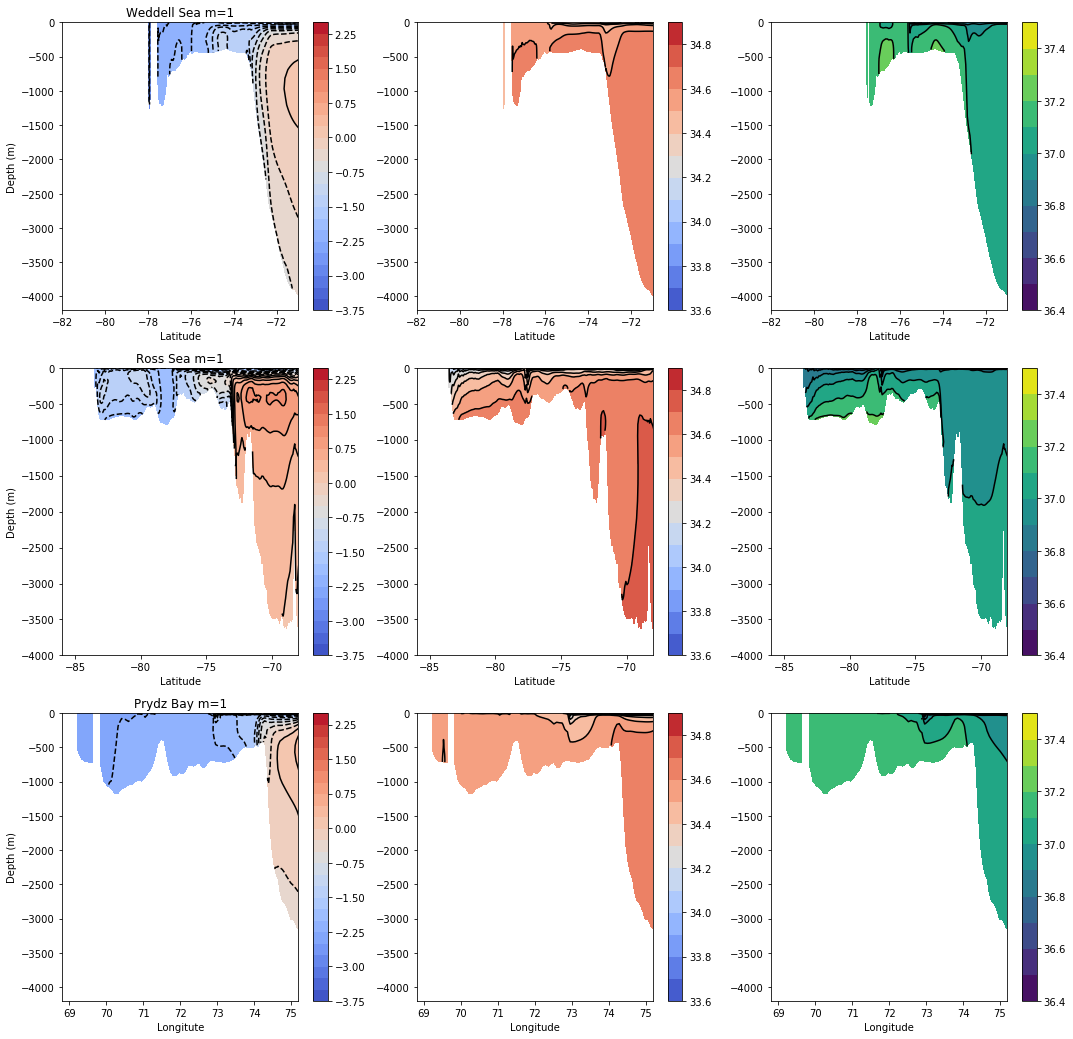

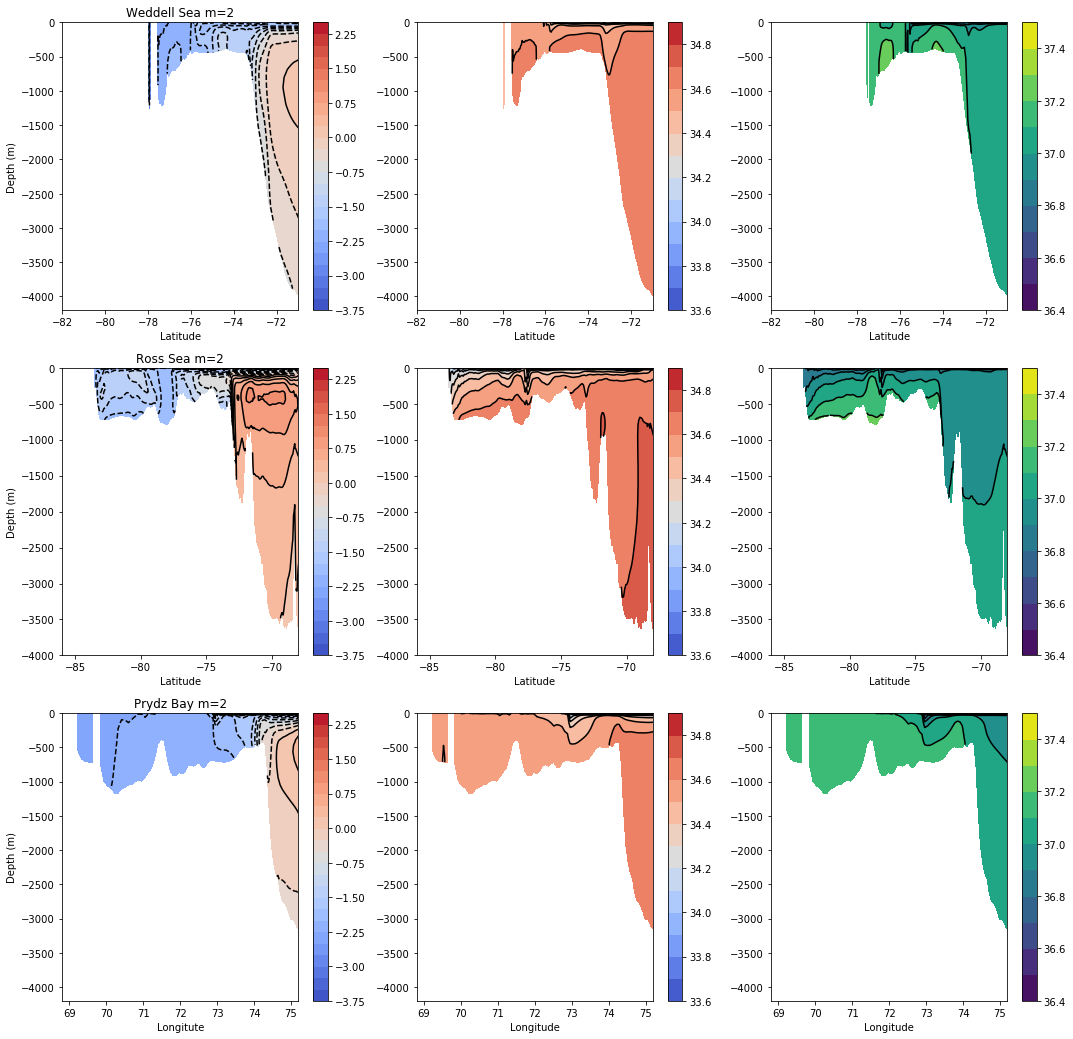

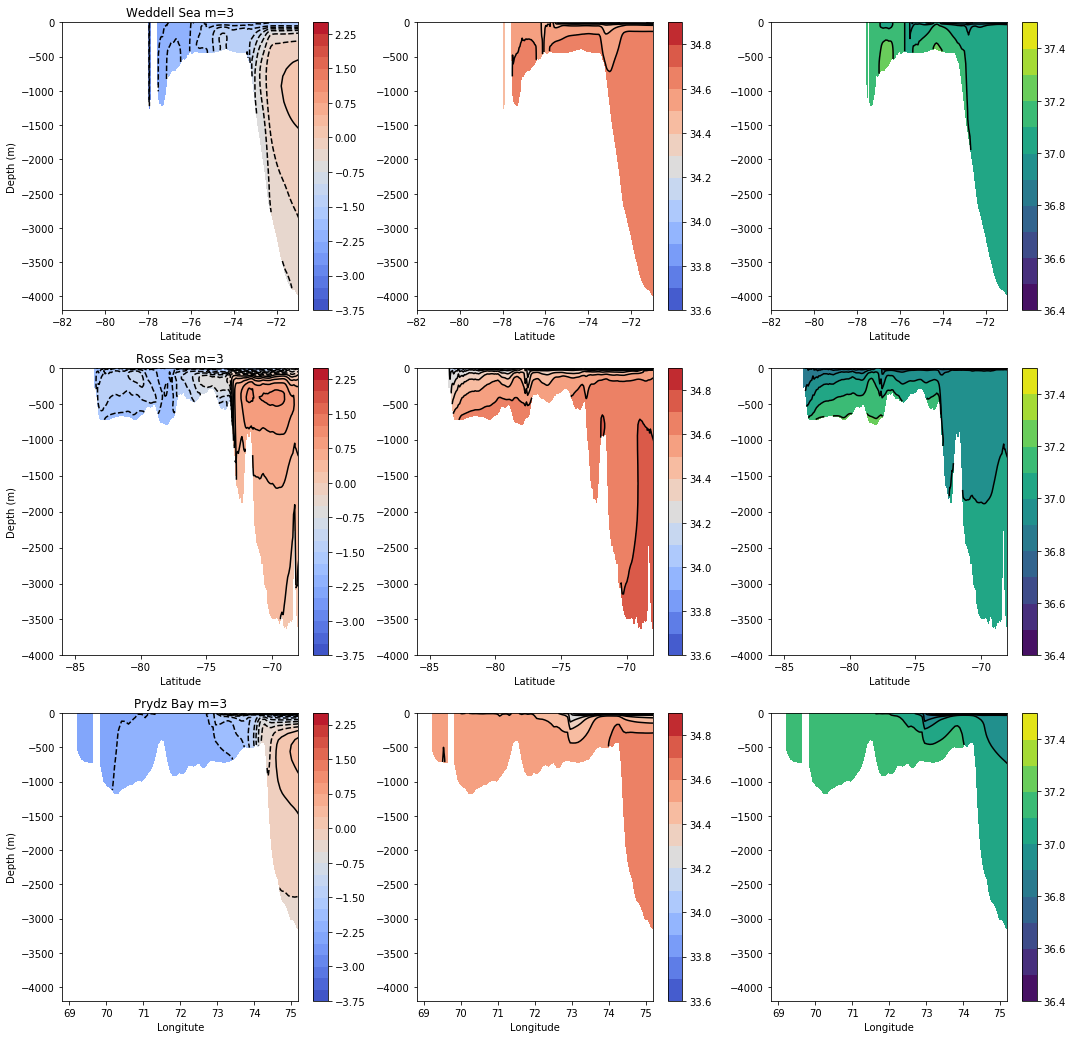

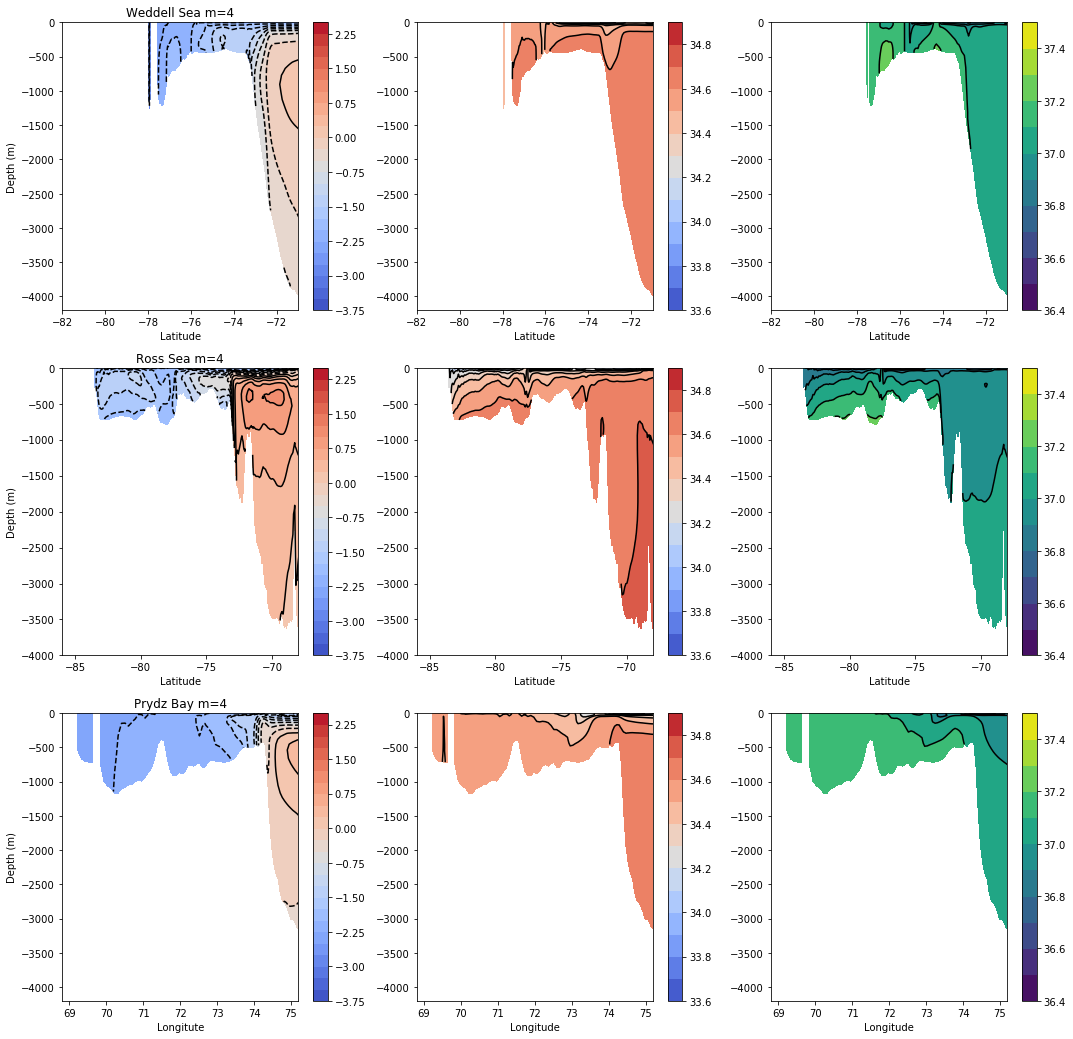

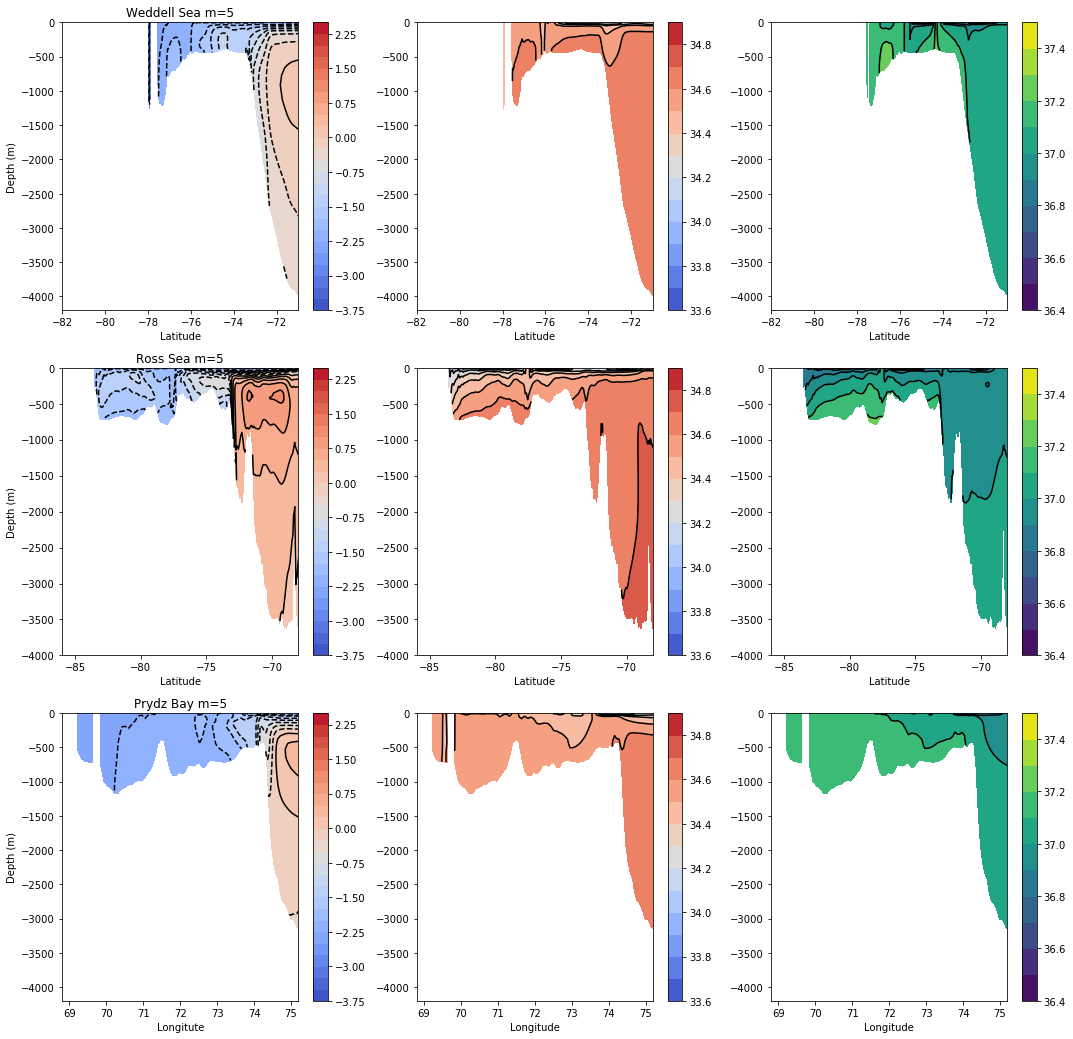

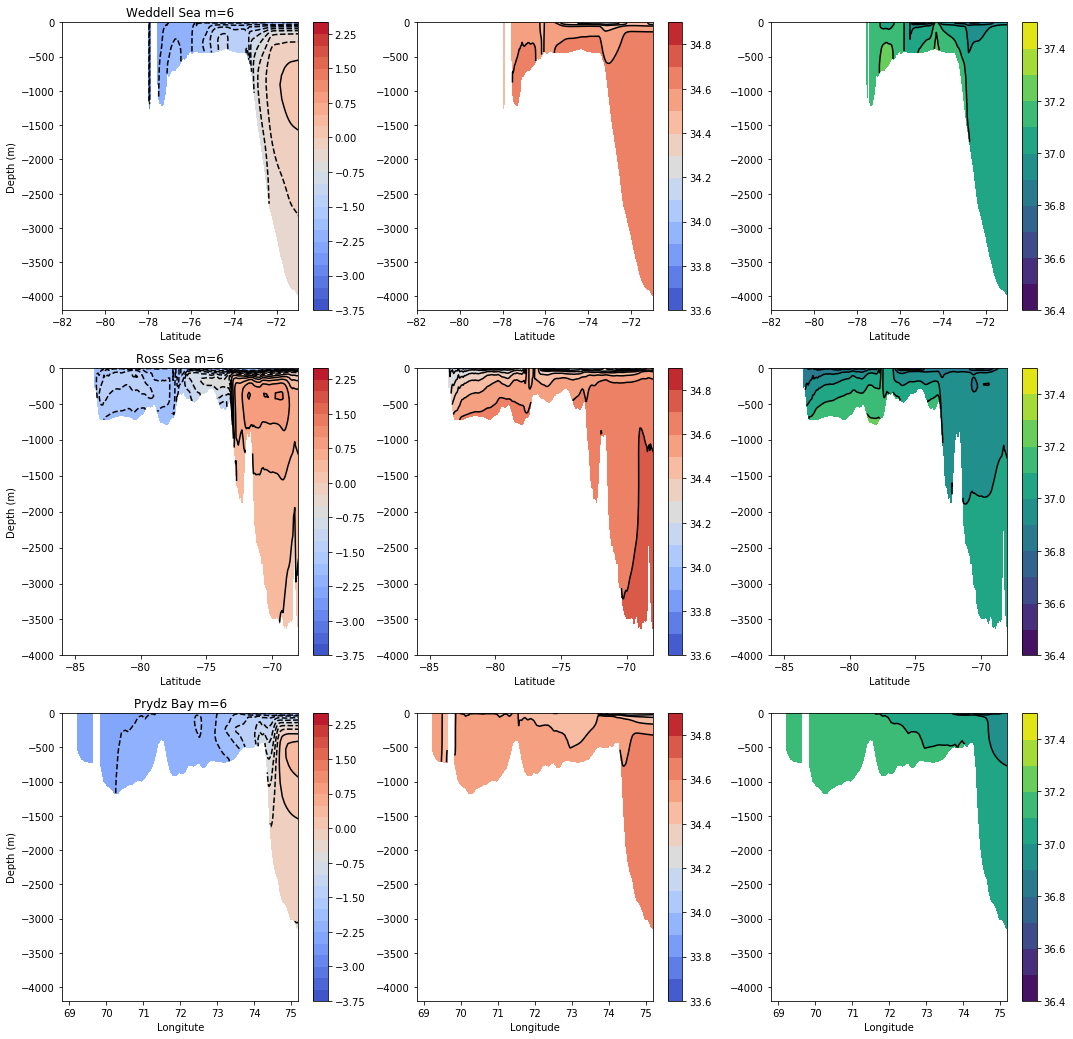

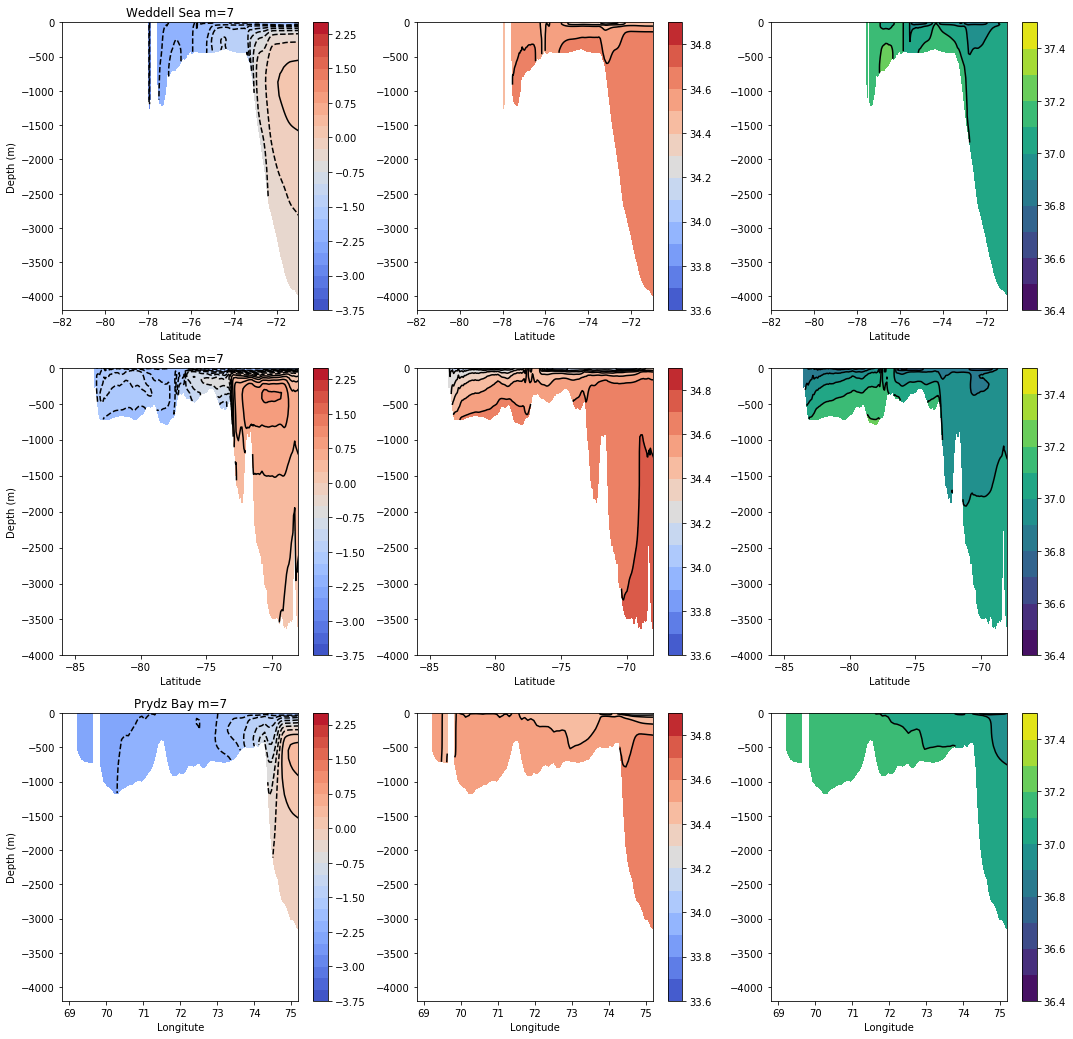

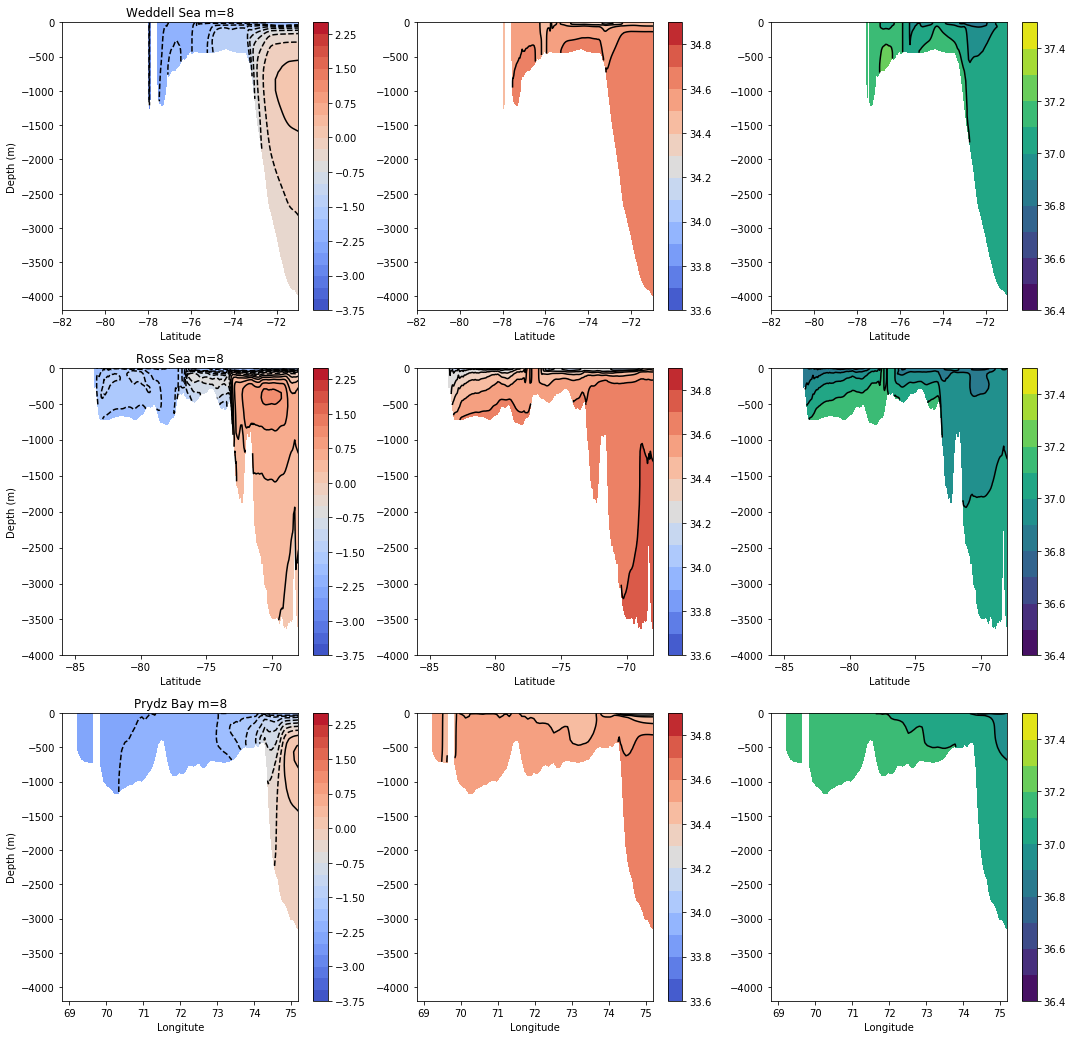

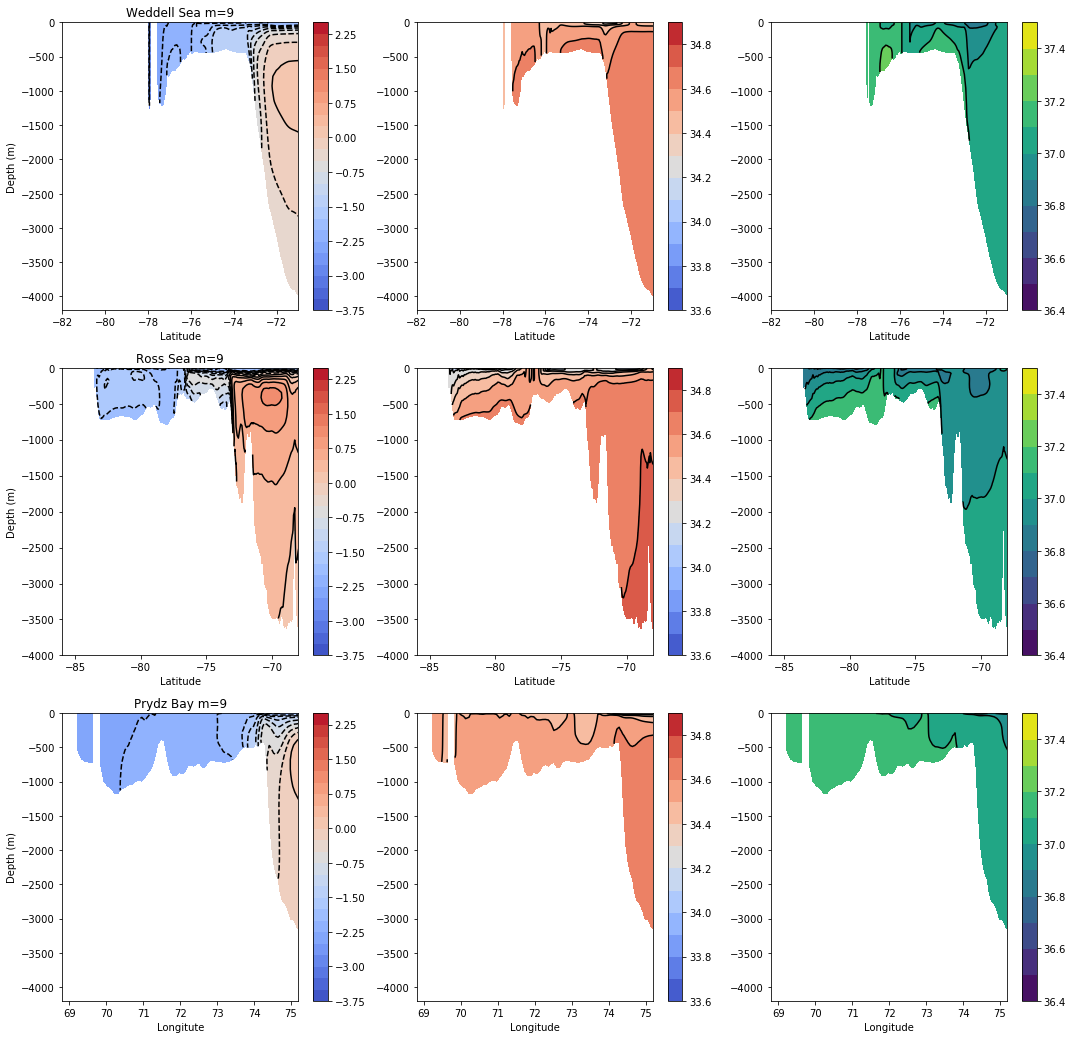

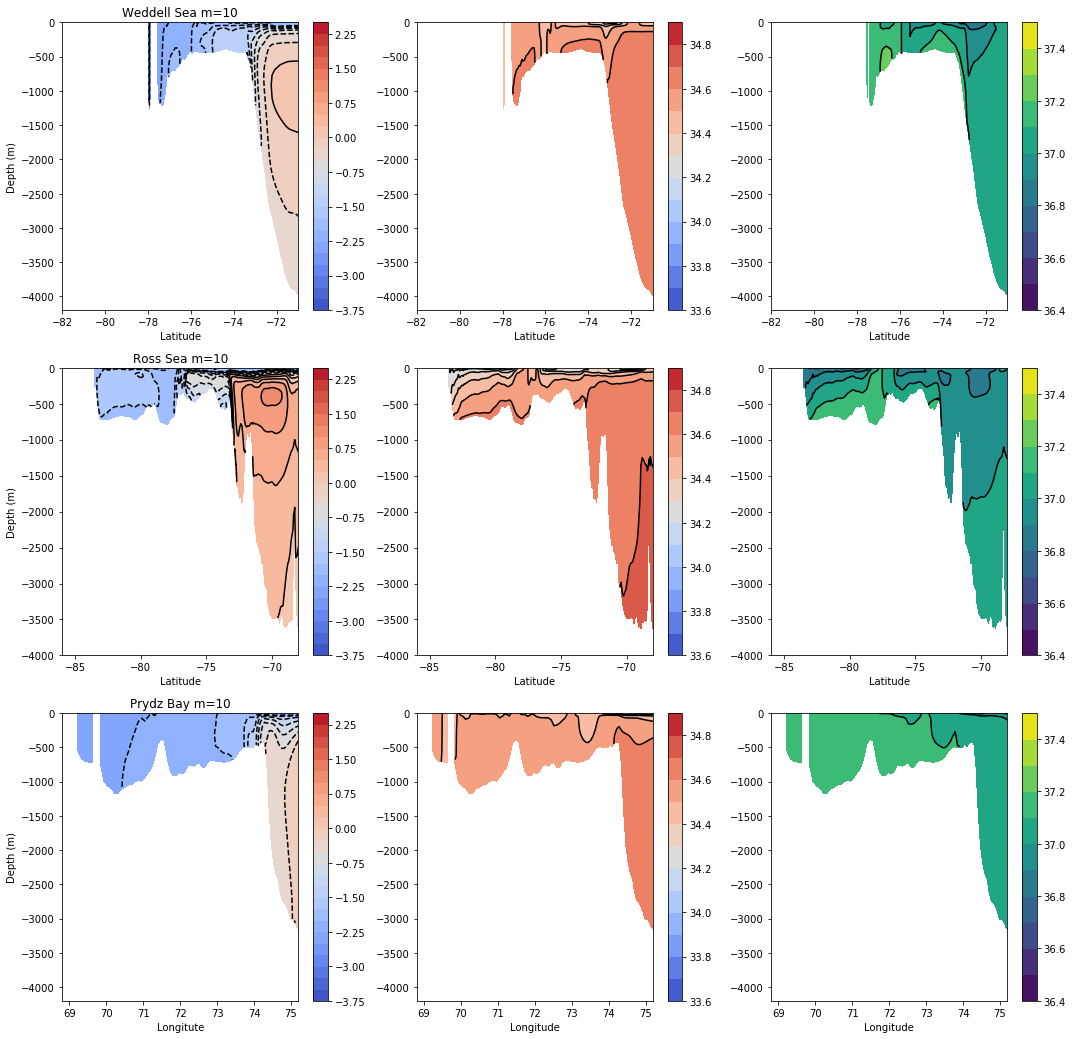

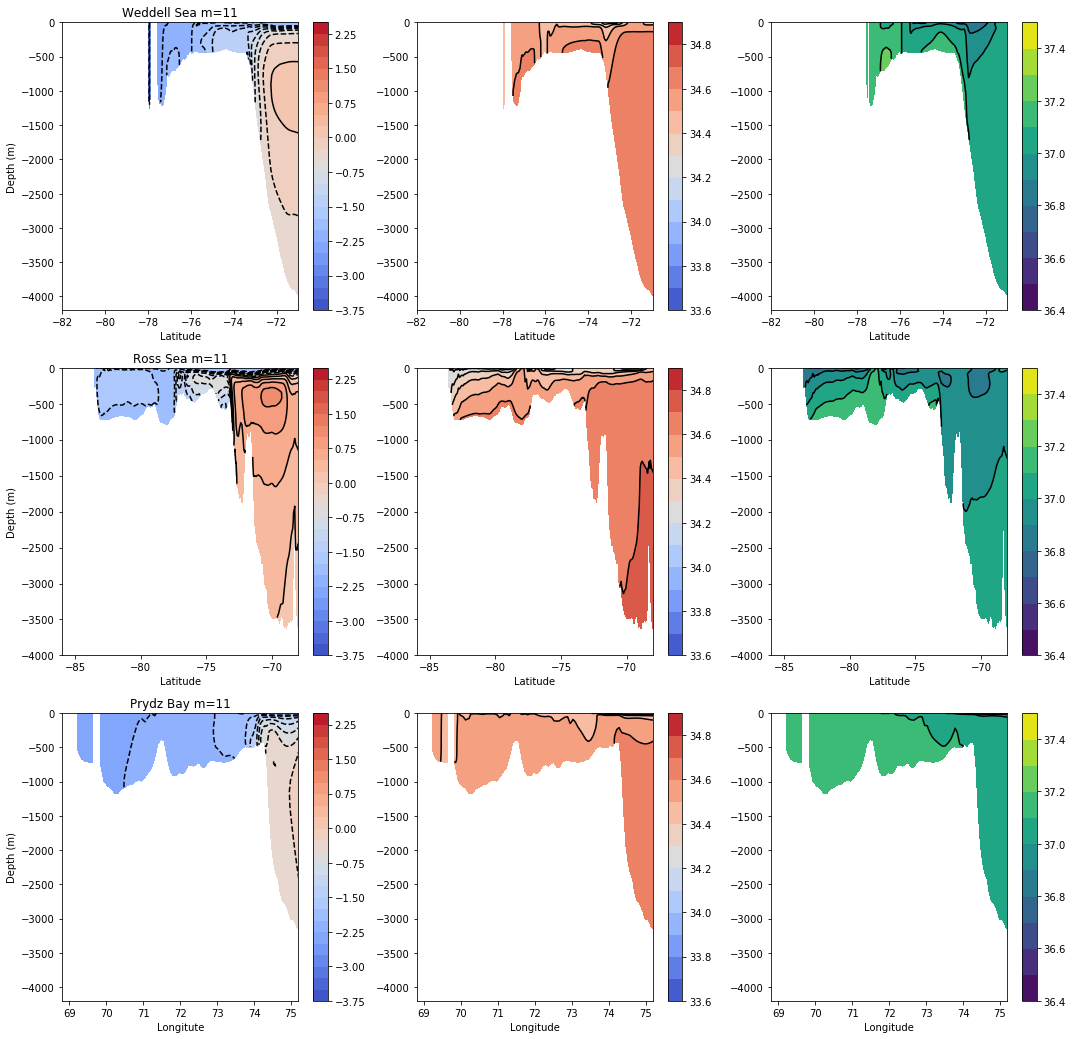

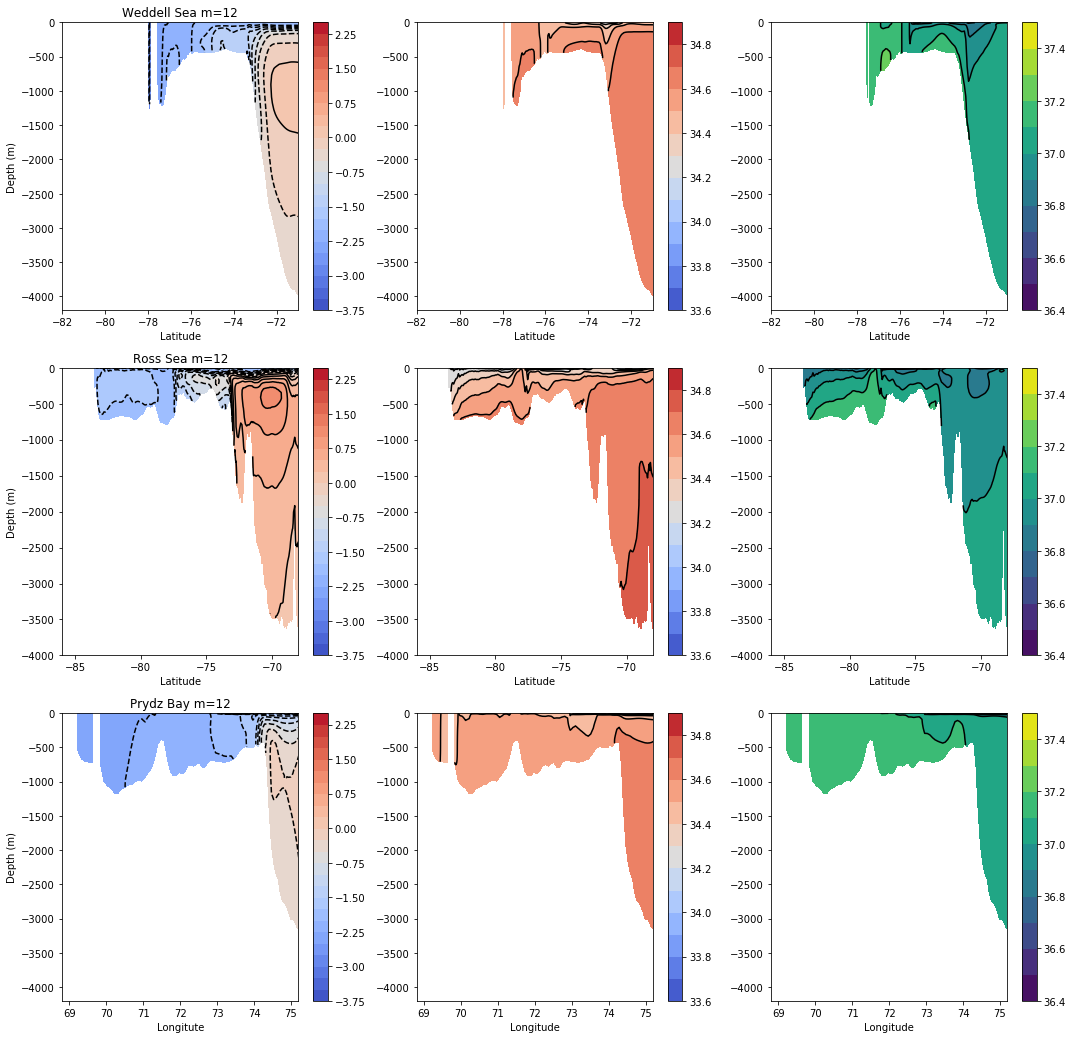

In [12]:
# Plots transects: Monthly


for mm in np.arange(0,12):
    # Weddell
    fig = plt.figure(figsize=(18,18))
    ax1 = fig.add_subplot(331)
    ct = plt.contourf(section_lat_wed_mask, np.squeeze(section_z_wed_mask[mm,:,:]), np.squeeze(section_temp_wed[mm,:,:]), levels=levelsT, cmap=plt.cm.coolwarm)
    plt.contour(section_lat_wed_mask, np.squeeze(section_z_wed_mask[mm,:,:]), np.squeeze(section_temp_wed[mm,:,:]), colors='k', levels=levelsT) #[-2.3,-2.1,-1.9,-1.5,-1.0,-.5,.0])
    plt.colorbar(ct, extend='both')
    plt.xlim([-82,-71])
    plt.ylim([-4200,0])
    plt.title('Weddell Sea m=' + str(mm+1))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude')

    ax2 = fig.add_subplot(332)
    cs = plt.contourf(section_lat_wed_mask, np.squeeze(section_z_wed_mask[mm,:,:]), np.squeeze(section_salt_wed[mm,:,:]), levels=levelsS, linestyle='dash', cmap=plt.cm.coolwarm)
    plt.contour(section_lat_wed_mask, np.squeeze(section_z_wed_mask[mm,:,:]), np.squeeze(section_salt_wed[mm,:,:]), colors='k', levels=levelsS, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([-82,-71])
    plt.ylim([-4200,0])
    plt.xlabel('Latitude')
    
    ax3 = fig.add_subplot(333)
    cs = plt.contourf(section_lat_wed_mask, np.squeeze(section_z_wed_mask[mm,:,:]), np.squeeze(section_rho_wed[mm,:,:]), levels=levelsR, linestyle='dash', cmap=plt.cm.viridis)
    plt.contour(section_lat_wed_mask, np.squeeze(section_z_wed_mask[mm,:,:]), np.squeeze(section_rho_wed[mm,:,:]), colors='k', levels=levelsR, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([-82,-71])
    plt.ylim([-4200,0])
    plt.xlabel('Latitude')        
    
    ax4 = fig.add_subplot(334)
    ct = plt.contourf(section_lat_ros_mask, np.squeeze(section_z_ros_mask[mm,:,:]), np.squeeze(section_temp_ros[mm,:,:]), levels=levelsT, cmap=plt.cm.coolwarm)
    plt.contour(section_lat_ros_mask, np.squeeze(section_z_ros_mask[mm,:,:]), np.squeeze(section_temp_ros[mm,:,:]), colors='k', levels=levelsT) #[-2.3,-2.1,-1.9,-1.5,-1.0,-.5,.0])
    plt.colorbar(ct, extend='both')
    plt.xlim([-86,-68])
    plt.ylim([-4000,0])
    plt.title('Ross Sea m=' + str(mm+1))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude')

    ax5 = fig.add_subplot(335)
    cs = plt.contourf(section_lat_ros_mask, np.squeeze(section_z_ros_mask[mm,:,:]), np.squeeze(section_salt_ros[mm,:,:]), levels=levelsS, linestyle='dash', cmap=plt.cm.coolwarm)
    plt.contour(section_lat_ros_mask, np.squeeze(section_z_ros_mask[mm,:,:]), np.squeeze(section_salt_ros[mm,:,:]), colors='k', levels=levelsS, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([-86,-68])
    plt.ylim([-4000,0])
    plt.xlabel('Latitude')
    
    ax6 = fig.add_subplot(336)
    cs = plt.contourf(section_lat_ros_mask, np.squeeze(section_z_ros_mask[mm,:,:]), np.squeeze(section_rho_ros[mm,:,:]), levels=levelsR, linestyle='dash', cmap=plt.cm.viridis)
    plt.contour(section_lat_ros_mask, np.squeeze(section_z_ros_mask[mm,:,:]), np.squeeze(section_rho_ros[mm,:,:]), colors='k', levels=levelsR, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([-86,-68])
    plt.ylim([-4000,0])
    plt.xlabel('Latitude')
    
    ax7 = fig.add_subplot(337)
    ct = plt.contourf(section_lon_pry_mask, np.squeeze(section_z_pry_mask[mm,:,:]), np.squeeze(section_temp_pry[mm,:,:]), levels=levelsT, cmap=plt.cm.coolwarm)
    plt.contour(section_lon_pry_mask, np.squeeze(section_z_pry_mask[mm,:,:]), np.squeeze(section_temp_pry[mm,:,:]), colors='k', levels=levelsT) #[-2.3,-2.1,-1.9,-1.5,-1.0,-.5,.0])
    plt.colorbar(ct, extend='both')
    plt.xlim([68.8,75.2])
    plt.ylim([-4200,0])
    plt.title('Prydz Bay m=' + str(mm+1))
    plt.ylabel('Depth (m)')
    plt.xlabel('Longitute')

    ax8 = fig.add_subplot(338)
    cs = plt.contourf(section_lon_pry_mask, np.squeeze(section_z_pry_mask[mm,:,:]), np.squeeze(section_salt_pry[mm,:,:]), levels=levelsS, linestyle='dash', cmap=plt.cm.coolwarm)
    plt.contour(section_lon_pry_mask, np.squeeze(section_z_pry_mask[mm,:,:]), np.squeeze(section_salt_pry[mm,:,:]), colors='k', levels=levelsS, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([68.8,75.2])
    plt.ylim([-4200,0])
    plt.xlabel('Longitude')

    ax9 = fig.add_subplot(339)
    cs = plt.contourf(section_lon_pry_mask, np.squeeze(section_z_pry_mask[mm,:,:]), np.squeeze(section_rho_pry[mm,:,:]), levels=levelsR, linestyle='dash', cmap=plt.cm.viridis)
    plt.contour(section_lon_pry_mask, np.squeeze(section_z_pry_mask[mm,:,:]), np.squeeze(section_rho_pry[mm,:,:]), colors='k', levels=levelsR, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([68.8,75.2])
    plt.ylim([-4200,0])
    plt.xlabel('Longitude')
    
    month=str(mm+1)

    name_fig="waom10_All_section_m=" + month + "_yr2.png"
    plt.savefig(fig_path + name_fig)

/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: The following kwargs were not used by contour: 'linestyle'
/opt/m

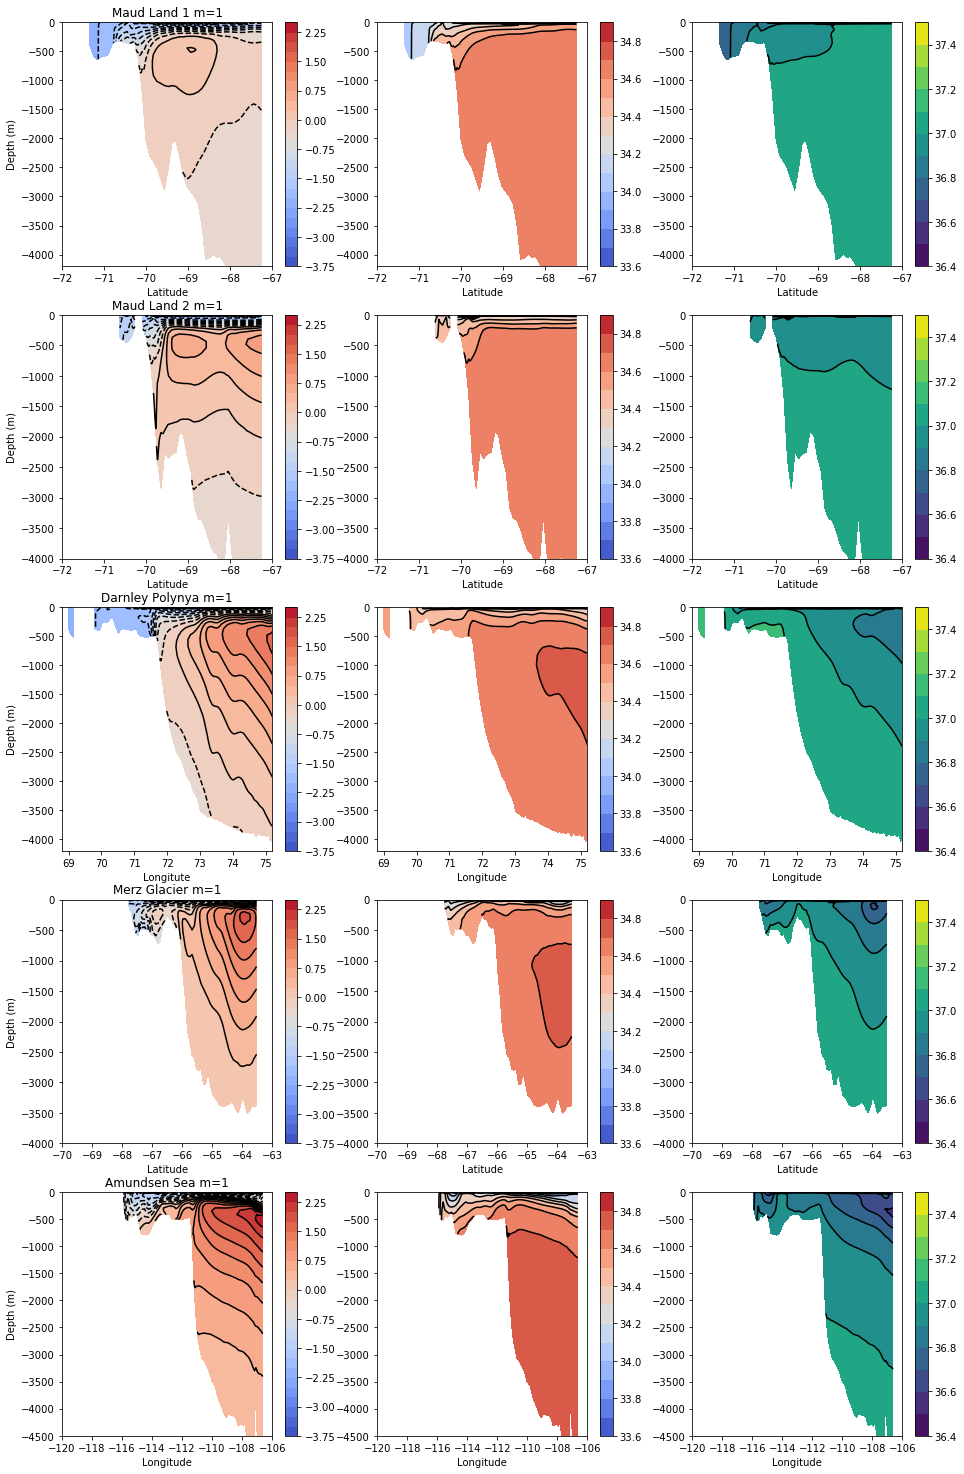

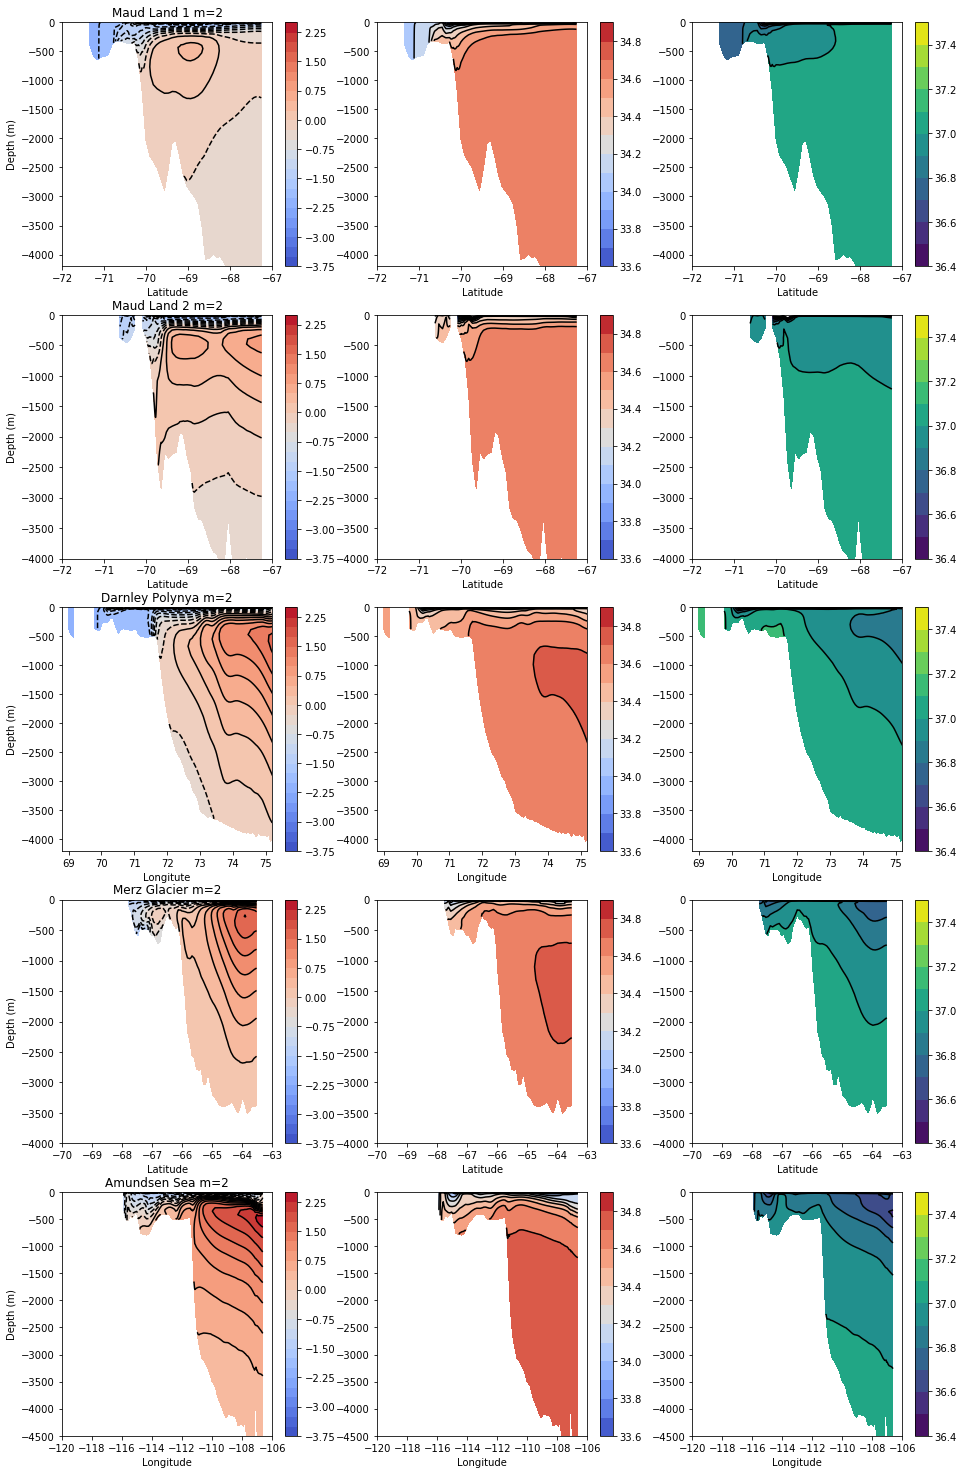

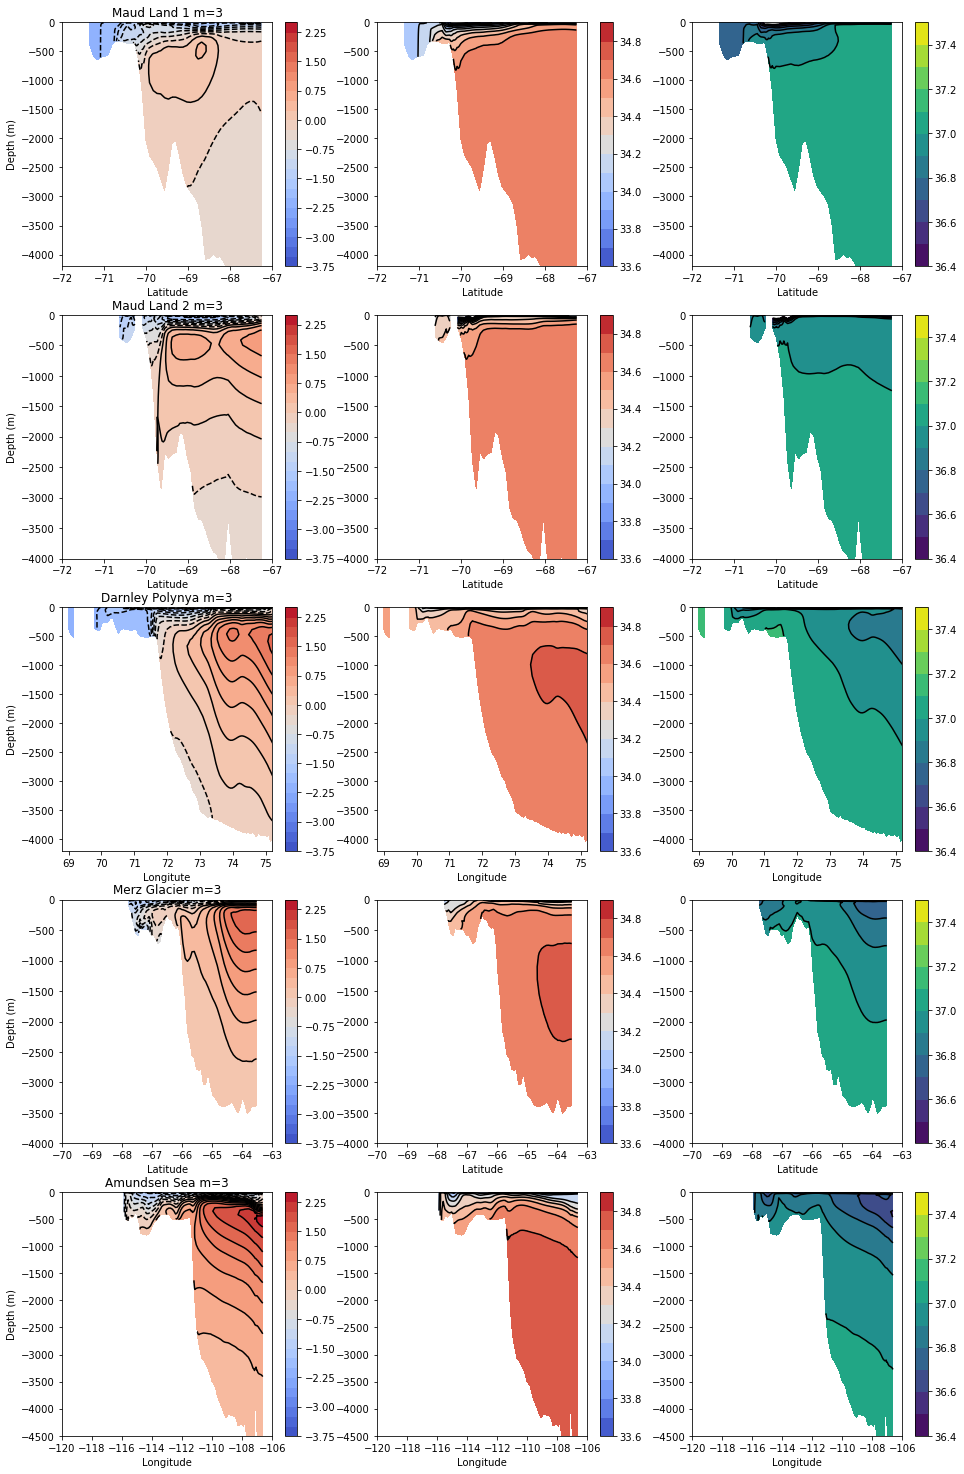

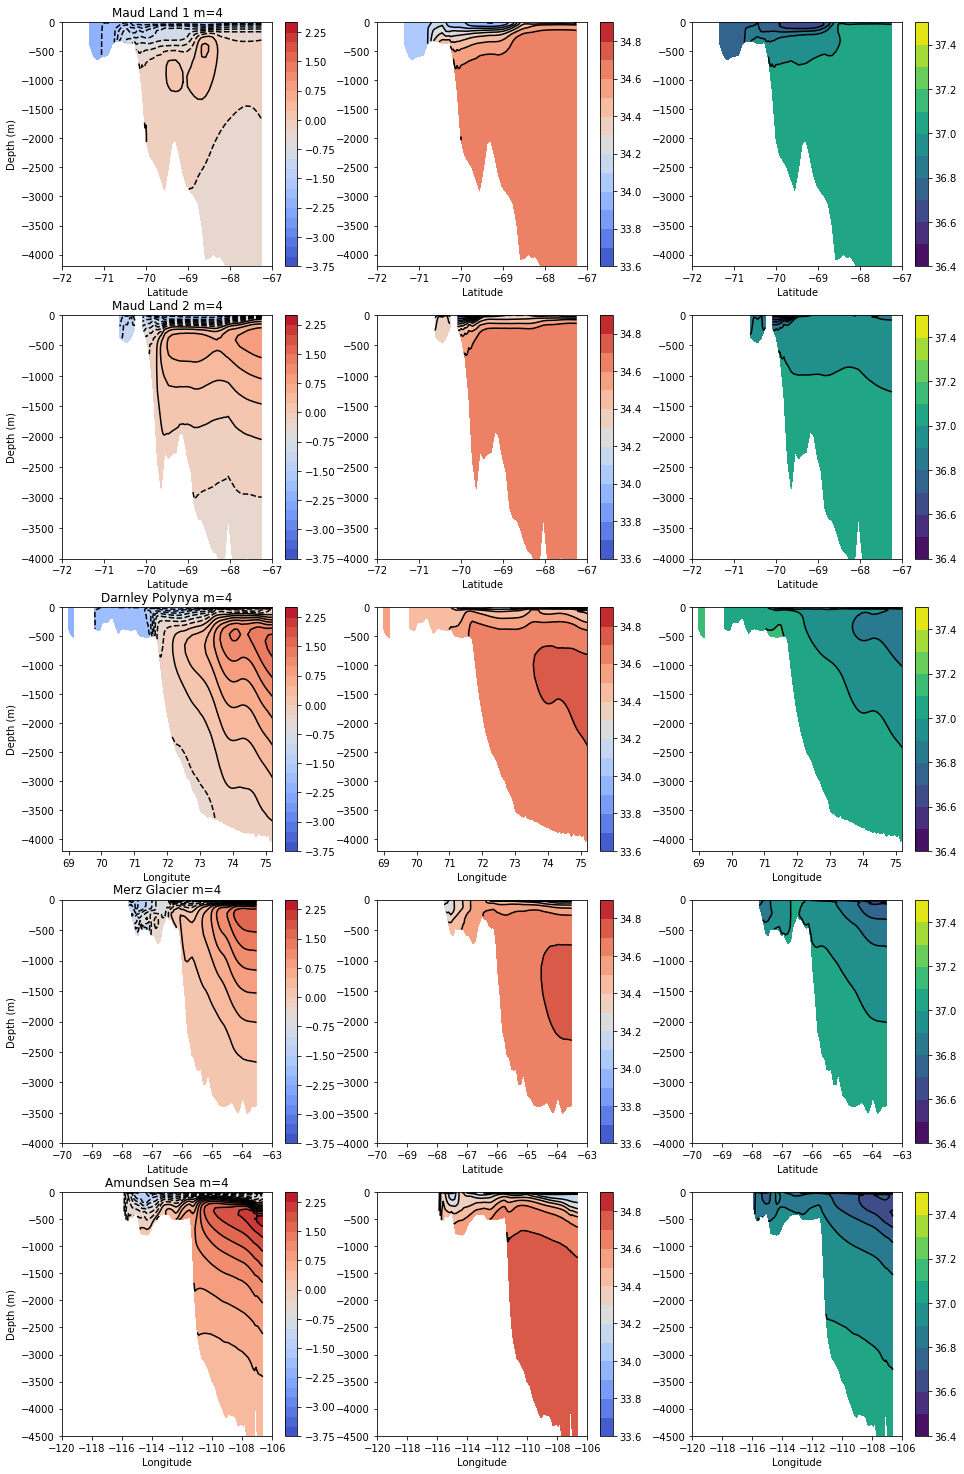

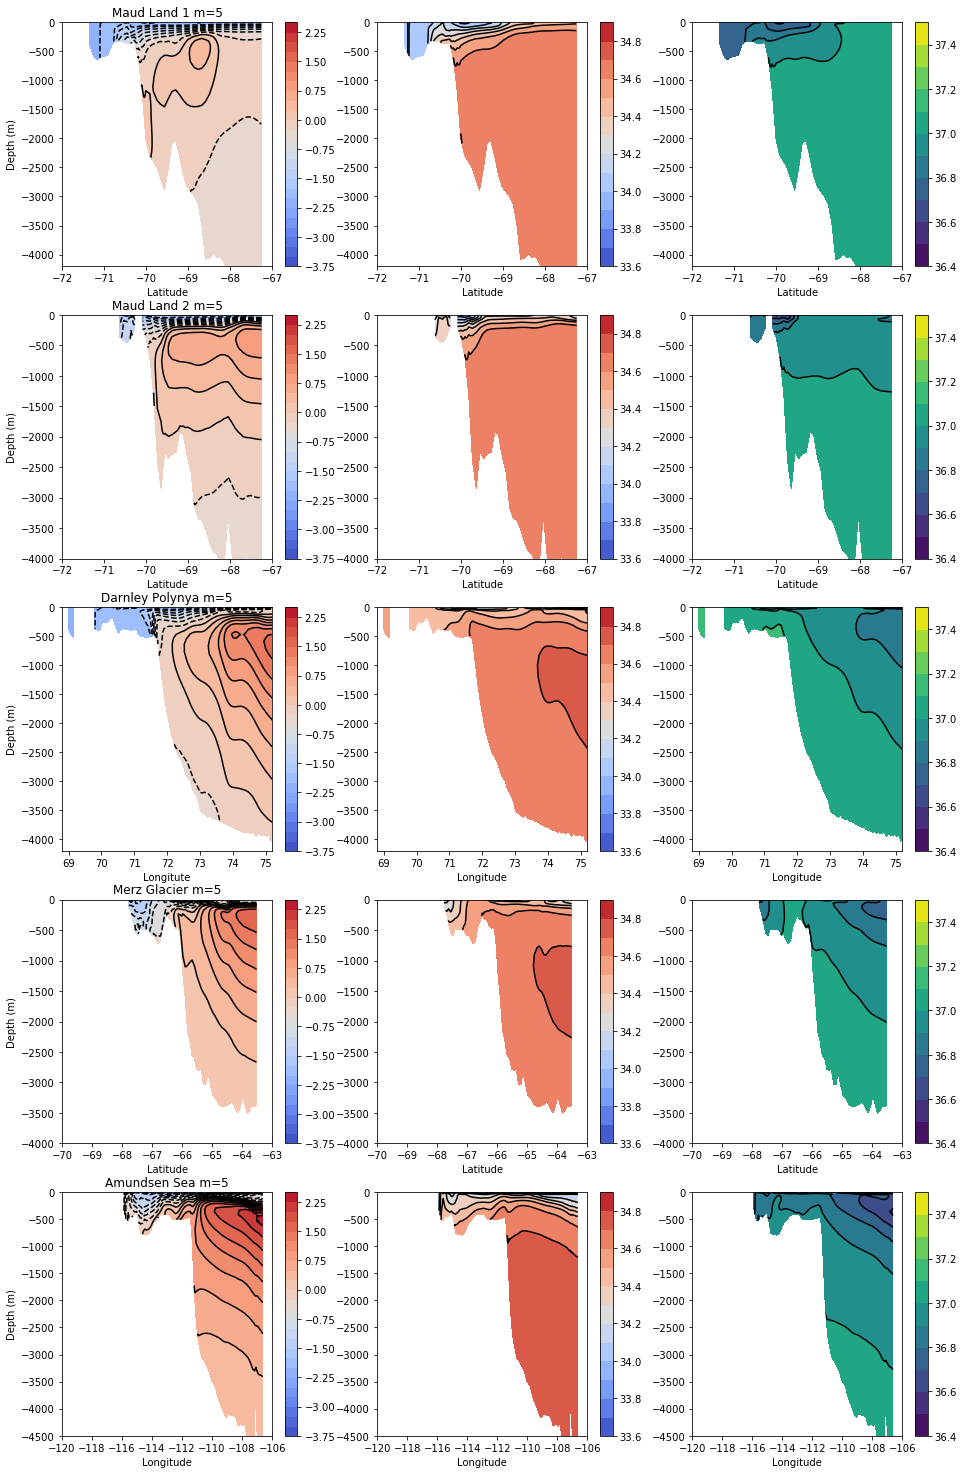

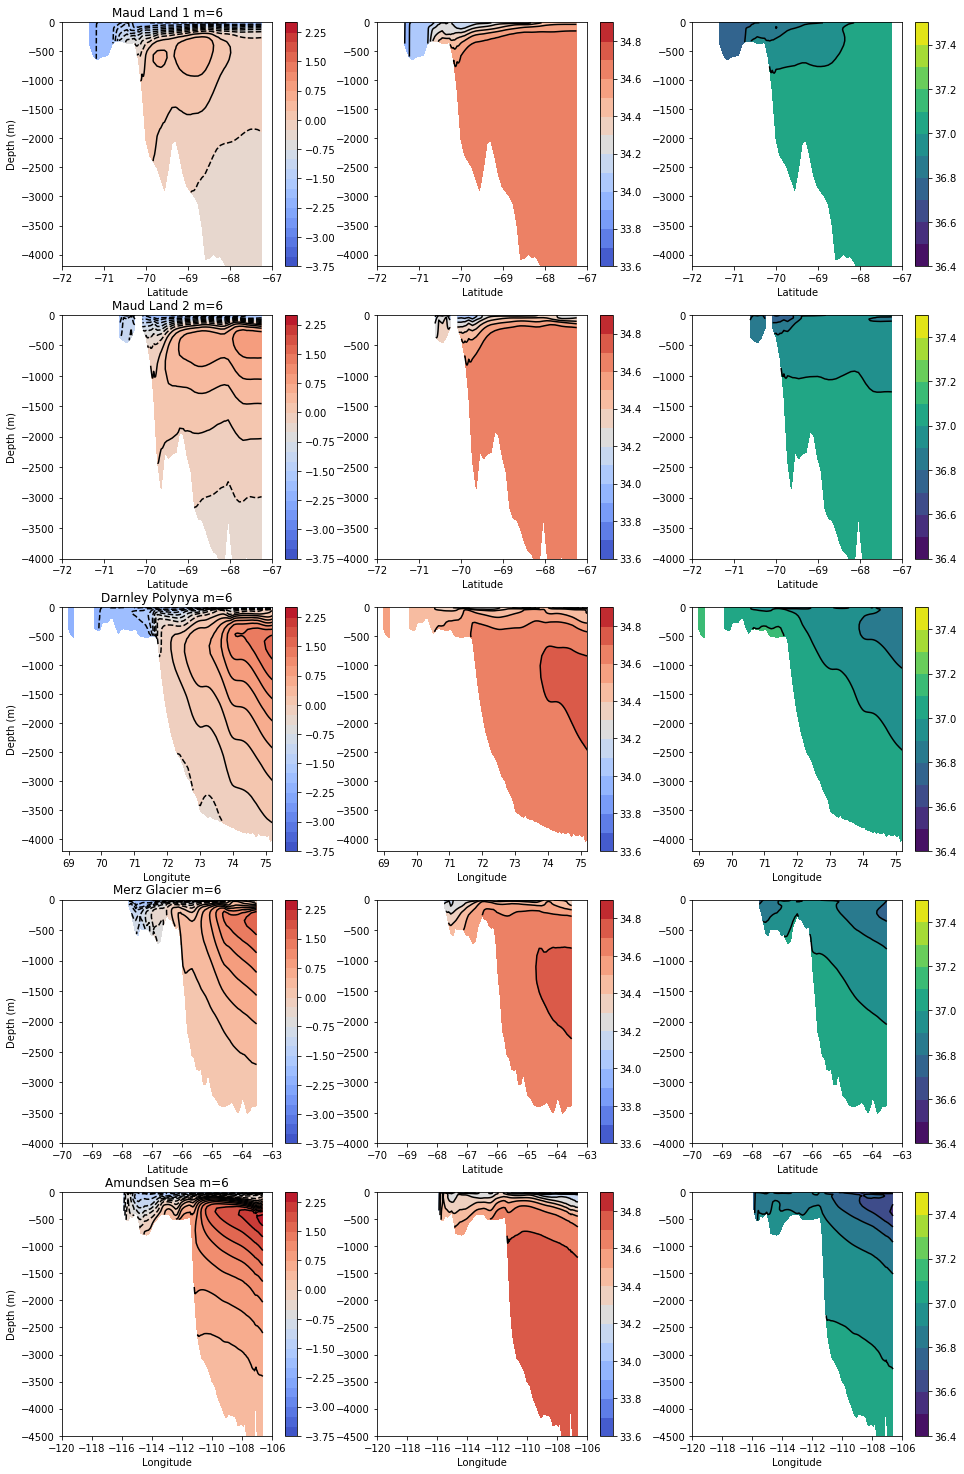

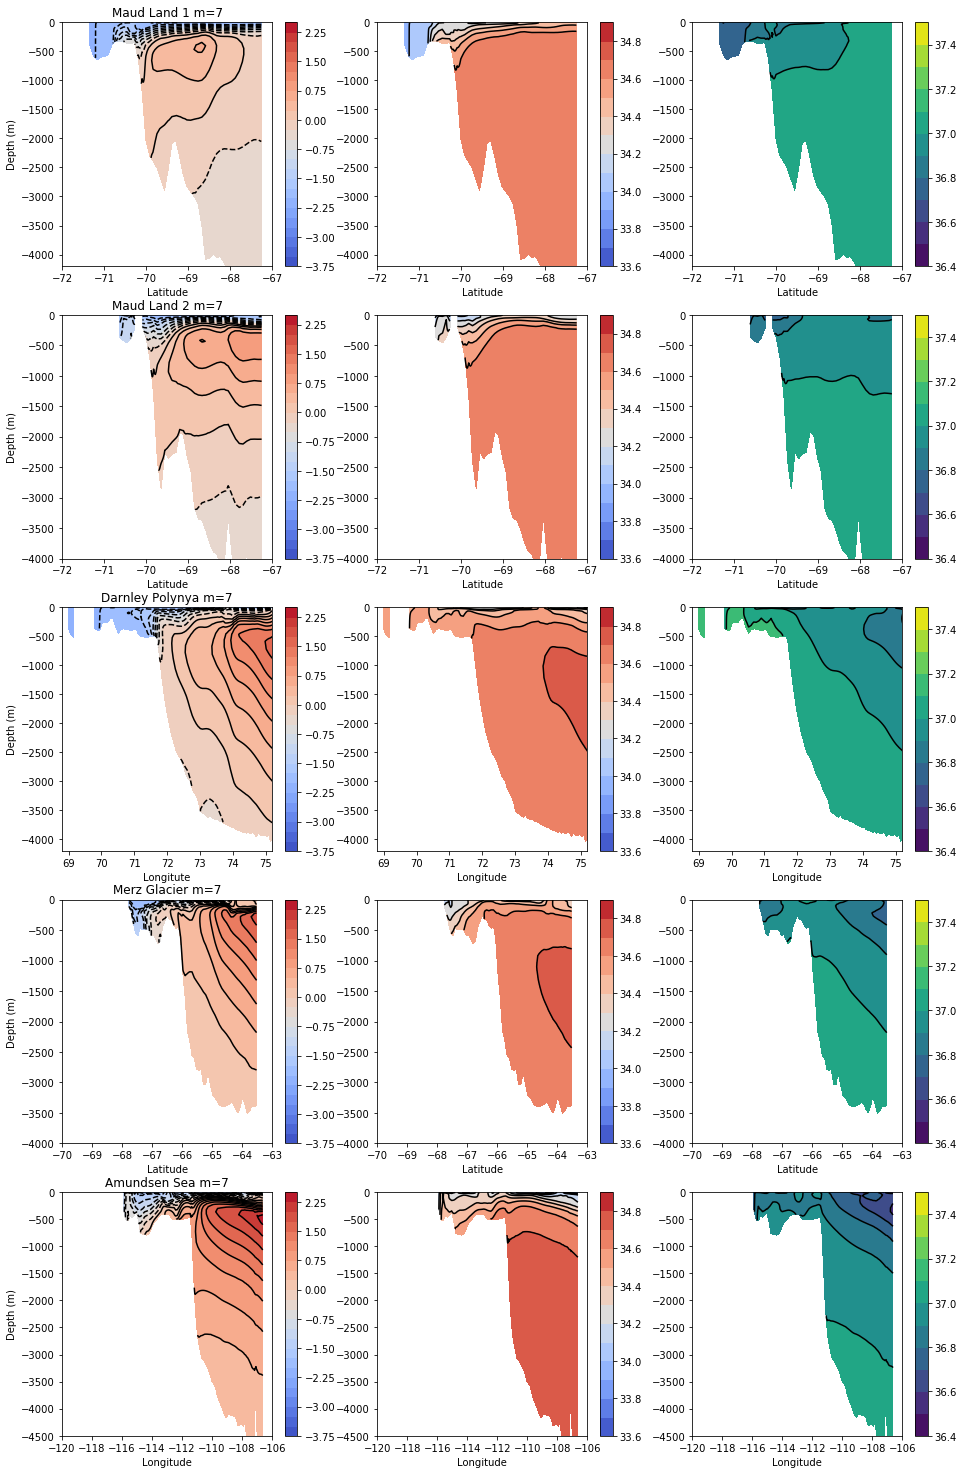

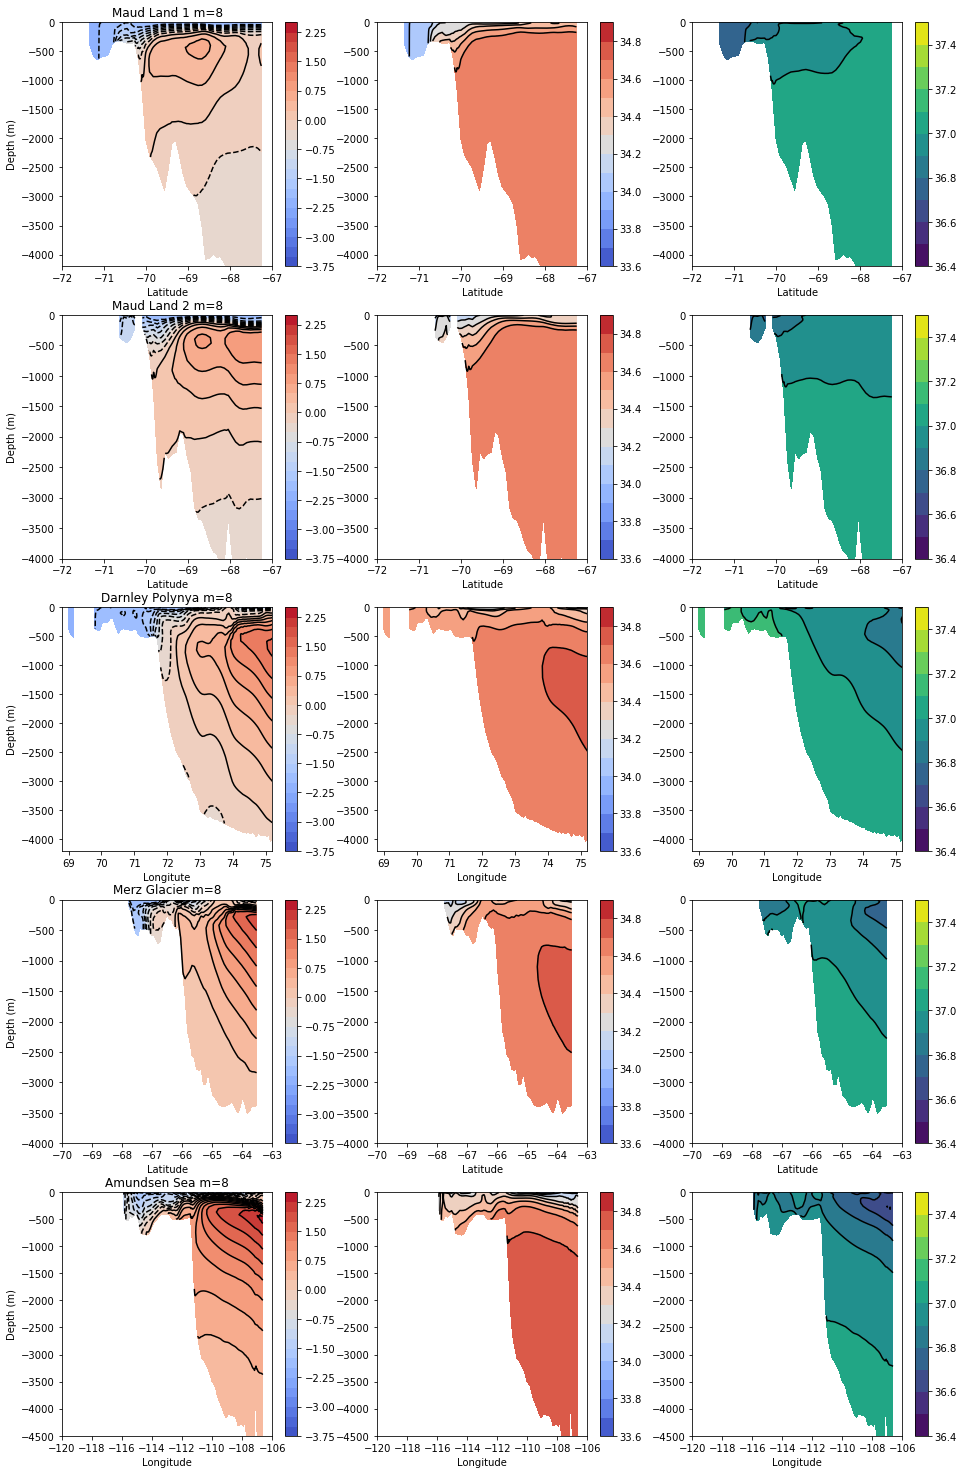

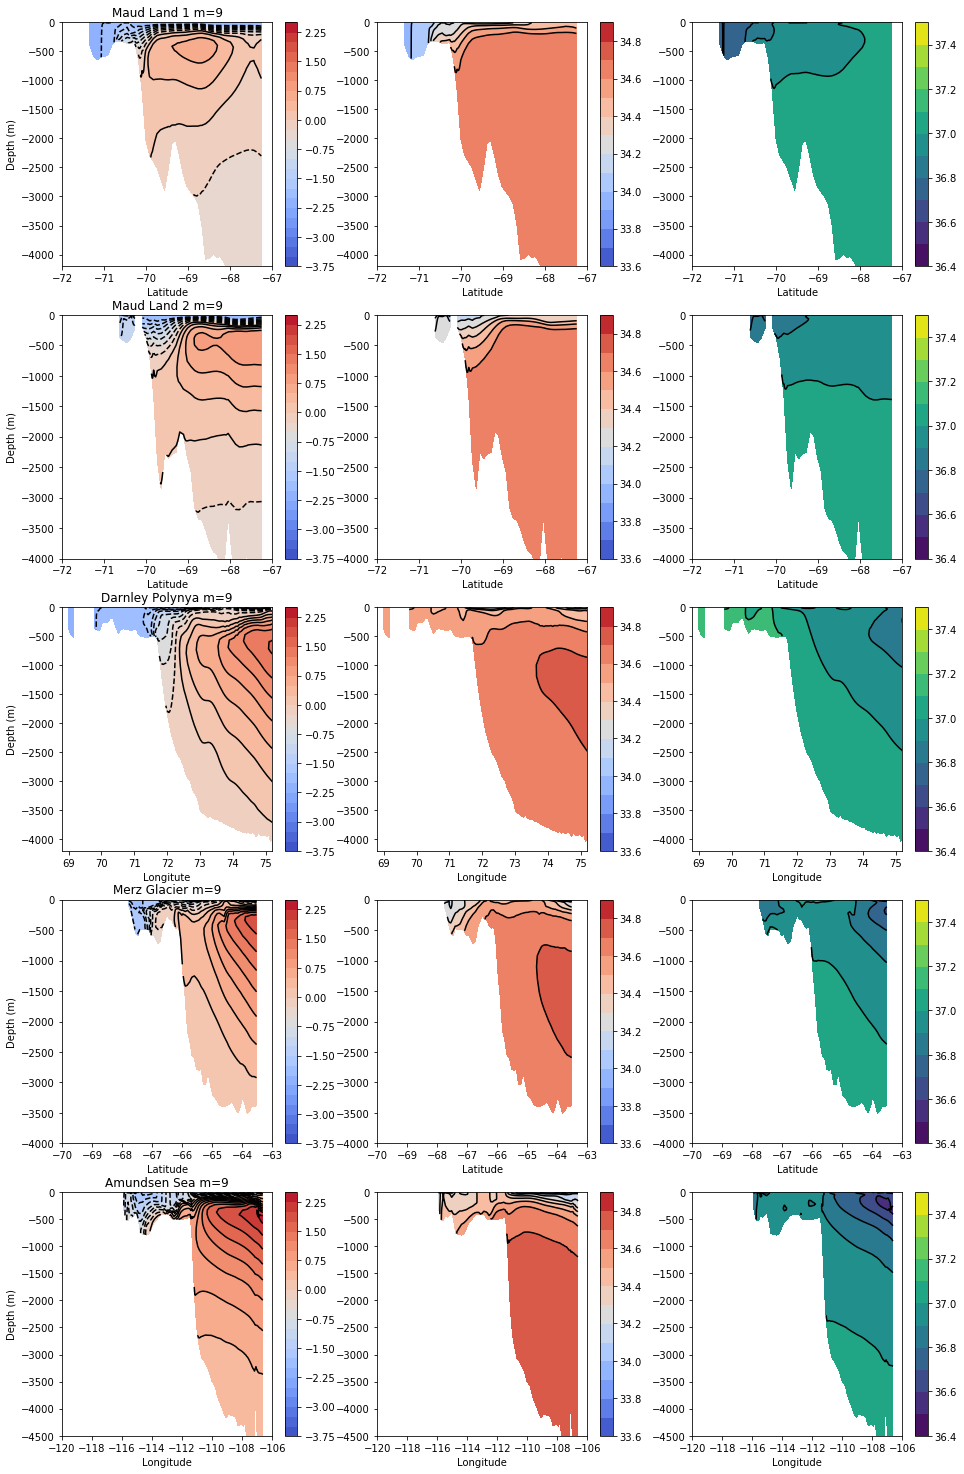

In [ ]:
# Plots transects: Monthly => New sections

for mm in np.arange(0,12):
    # Neu
    fig = plt.figure(figsize=(16,26))
    ax1 = fig.add_subplot(5,3,1)
    ct = plt.contourf(section_lat_neu_mask, np.squeeze(section_z_neu_mask[mm,:,:]), np.squeeze(section_temp_neu[mm,:,:]), levels=levelsT, cmap=plt.cm.coolwarm)
    plt.contour(section_lat_neu_mask, np.squeeze(section_z_neu_mask[mm,:,:]), np.squeeze(section_temp_neu[mm,:,:]), colors='k', levels=levelsT) #[-2.3,-2.1,-1.9,-1.5,-1.0,-.5,.0])
    plt.colorbar(ct, extend='both')
    plt.xlim([-72,-67])
    plt.ylim([-4200,0])
    plt.title('Maud Land 1 m=' + str(mm+1))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude')

    ax2 = fig.add_subplot(5,3,2)
    cs = plt.contourf(section_lat_neu_mask, np.squeeze(section_z_neu_mask[mm,:,:]), np.squeeze(section_salt_neu[mm,:,:]), levels=levelsS, linestyle='dash', cmap=plt.cm.coolwarm)
    plt.contour(section_lat_neu_mask, np.squeeze(section_z_neu_mask[mm,:,:]), np.squeeze(section_salt_neu[mm,:,:]), colors='k', levels=levelsS, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([-72,-67])
    plt.ylim([-4200,0])
    plt.xlabel('Latitude')
    
    ax3 = fig.add_subplot(5,3,3)
    cs = plt.contourf(section_lat_neu_mask, np.squeeze(section_z_neu_mask[mm,:,:]), np.squeeze(section_rho_neu[mm,:,:]), levels=levelsR, linestyle='dash', cmap=plt.cm.viridis)
    plt.contour(section_lat_neu_mask, np.squeeze(section_z_neu_mask[mm,:,:]), np.squeeze(section_rho_neu[mm,:,:]), colors='k', levels=levelsR, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([-72,-67])
    plt.ylim([-4200,0])
    plt.xlabel('Latitude')
    
    ax4 = fig.add_subplot(5,3,4)
    ct = plt.contourf(section_lat_mai_mask, np.squeeze(section_z_mai_mask[mm,:,:]), np.squeeze(section_temp_mai[mm,:,:]), levels=levelsT, cmap=plt.cm.coolwarm)
    plt.contour(section_lat_mai_mask, np.squeeze(section_z_mai_mask[mm,:,:]), np.squeeze(section_temp_mai[mm,:,:]), colors='k', levels=levelsT) #[-2.3,-2.1,-1.9,-1.5,-1.0,-.5,.0])
    plt.colorbar(ct, extend='both')
    plt.xlim([-72,-67])
    plt.ylim([-4000,0])
    plt.title('Maud Land 2 m=' + str(mm+1))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude')

    ax5 = fig.add_subplot(5,3,5)
    cs = plt.contourf(section_lat_mai_mask, np.squeeze(section_z_mai_mask[mm,:,:]), np.squeeze(section_salt_mai[mm,:,:]), levels=levelsS, linestyle='dash', cmap=plt.cm.coolwarm)
    plt.contour(section_lat_mai_mask, np.squeeze(section_z_mai_mask[mm,:,:]), np.squeeze(section_salt_mai[mm,:,:]), colors='k', levels=levelsS, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([-72,-67])
    plt.ylim([-4000,0])
    plt.xlabel('Latitude')
    
    ax6 = fig.add_subplot(5,3,6)
    cs = plt.contourf(section_lat_mai_mask, np.squeeze(section_z_mai_mask[mm,:,:]), np.squeeze(section_rho_mai[mm,:,:]), levels=levelsR, linestyle='dash', cmap=plt.cm.viridis)
    plt.contour(section_lat_mai_mask, np.squeeze(section_z_mai_mask[mm,:,:]), np.squeeze(section_rho_mai[mm,:,:]), colors='k', levels=levelsR, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([-72,-67])
    plt.ylim([-4000,0])
    plt.xlabel('Latitude')
    
    ax7 = fig.add_subplot(5,3,7)
    ct = plt.contourf(section_lon_dar_mask, np.squeeze(section_z_dar_mask[mm,:,:]), np.squeeze(section_temp_dar[mm,:,:]), levels=levelsT, cmap=plt.cm.coolwarm)
    plt.contour(section_lon_dar_mask, np.squeeze(section_z_dar_mask[mm,:,:]), np.squeeze(section_temp_dar[mm,:,:]), colors='k', levels=levelsT) #[-2.3,-2.1,-1.9,-1.5,-1.0,-.5,.0])
    plt.colorbar(ct, extend='both')
    plt.xlim([68.8,75.2])
    plt.ylim([-4200,0])
    plt.title('Darnley Polynya m=' + str(mm+1))
    plt.ylabel('Depth (m)')
    plt.xlabel('Longitute')

    ax8 = fig.add_subplot(5,3,8)
    cs = plt.contourf(section_lon_dar_mask, np.squeeze(section_z_dar_mask[mm,:,:]), np.squeeze(section_salt_dar[mm,:,:]), levels=levelsS, linestyle='dash', cmap=plt.cm.coolwarm)
    plt.contour(section_lon_dar_mask, np.squeeze(section_z_dar_mask[mm,:,:]), np.squeeze(section_salt_dar[mm,:,:]), colors='k', levels=levelsS, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([68.8,75.2])
    plt.ylim([-4200,0])
    plt.xlabel('Longitude')

    ax9 = fig.add_subplot(5,3,9)
    cs = plt.contourf(section_lon_dar_mask, np.squeeze(section_z_dar_mask[mm,:,:]), np.squeeze(section_rho_dar[mm,:,:]), levels=levelsR, linestyle='dash', cmap=plt.cm.viridis)
    plt.contour(section_lon_dar_mask, np.squeeze(section_z_dar_mask[mm,:,:]), np.squeeze(section_rho_dar[mm,:,:]), colors='k', levels=levelsR, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([68.8,75.2])
    plt.ylim([-4200,0])
    plt.xlabel('Longitude')
    
    ax10 = fig.add_subplot(5,3,10)
    ct = plt.contourf(section_lat_mer_mask, np.squeeze(section_z_mer_mask[mm,:,:]), np.squeeze(section_temp_mer[mm,:,:]), levels=levelsT, cmap=plt.cm.coolwarm)
    plt.contour(section_lat_mer_mask, np.squeeze(section_z_mer_mask[mm,:,:]), np.squeeze(section_temp_mer[mm,:,:]), colors='k', levels=levelsT) #[-2.3,-2.1,-1.9,-1.5,-1.0,-.5,.0])
    plt.colorbar(ct, extend='both')
    plt.xlim([-70,-63])
    plt.ylim([-4000,0])
    plt.title('Merz Glacier m=' + str(mm+1))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude')

    ax11 = fig.add_subplot(5,3,11)
    cs = plt.contourf(section_lat_mer_mask, np.squeeze(section_z_mer_mask[mm,:,:]), np.squeeze(section_salt_mer[mm,:,:]), levels=levelsS, linestyle='dash', cmap=plt.cm.coolwarm)
    plt.contour(section_lat_mer_mask, np.squeeze(section_z_mer_mask[mm,:,:]), np.squeeze(section_salt_mer[mm,:,:]), colors='k', levels=levelsS, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([-70,-63])
    plt.ylim([-4000,0])
    plt.xlabel('Latitude')

    ax12 = fig.add_subplot(5,3,12)
    cs = plt.contourf(section_lat_mer_mask, np.squeeze(section_z_mer_mask[mm,:,:]), np.squeeze(section_rho_mer[mm,:,:]), levels=levelsR, linestyle='dash', cmap=plt.cm.viridis)
    plt.contour(section_lat_mer_mask, np.squeeze(section_z_mer_mask[mm,:,:]), np.squeeze(section_rho_mer[mm,:,:]), colors='k', levels=levelsR, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([-70,-63])
    plt.ylim([-4000,0])
    plt.xlabel('Latitude')


    ax13 = fig.add_subplot(5,3,13)
    ct = plt.contourf(section_lon_amu_mask, np.squeeze(section_z_amu_mask[mm,:,:]), np.squeeze(section_temp_amu[mm,:,:]), levels=levelsT, cmap=plt.cm.coolwarm)
    plt.contour(section_lon_amu_mask, np.squeeze(section_z_amu_mask[mm,:,:]), np.squeeze(section_temp_amu[mm,:,:]), colors='k', levels=levelsT) #[-2.3,-2.1,-1.9,-1.5,-1.0,-.5,.0])
    plt.colorbar(ct, extend='both')
    plt.xlim([-120,-106])
    plt.ylim([-4500,0])
    plt.title('Amundsen Sea m=' + str(mm+1))
    plt.ylabel('Depth (m)')
    plt.xlabel('Longitude')

    ax14 = fig.add_subplot(5,3,14)
    cs = plt.contourf(section_lon_amu_mask, np.squeeze(section_z_amu_mask[mm,:,:]), np.squeeze(section_salt_amu[mm,:,:]), levels=levelsS, linestyle='dash', cmap=plt.cm.coolwarm)
    plt.contour(section_lon_amu_mask, np.squeeze(section_z_amu_mask[mm,:,:]), np.squeeze(section_salt_amu[mm,:,:]), colors='k', levels=levelsS, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([-120,-106])
    plt.ylim([-4500,0])
    plt.xlabel('Longitude')
    
    ax15 = fig.add_subplot(5,3,15)
    cs = plt.contourf(section_lon_amu_mask, np.squeeze(section_z_amu_mask[mm,:,:]), np.squeeze(section_rho_amu[mm,:,:]), levels=levelsR, linestyle='dash', cmap=plt.cm.viridis)
    plt.contour(section_lon_amu_mask, np.squeeze(section_z_amu_mask[mm,:,:]), np.squeeze(section_rho_amu[mm,:,:]), colors='k', levels=levelsR, linestyle='dashed') #[34.3,34.45,34.5,34.55,34.6])
    plt.colorbar(cs, extend='both')
    plt.xlim([-120,-106])
    plt.ylim([-4500,0])
    plt.xlabel('Longitude')
    
    month=str(mm+1)

    name_fig="waom10_All_newsection_m=" + month + "_yr2.png"
    plt.savefig(fig_path + name_fig)

In [ ]:
# Plot transects: Seasonal

# Weddell
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lat_wed_mask, section_z_wed_mask_JFM, section_temp_wed_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wed_mask, section_z_wed_mask_JFM, section_temp_wed_JFM, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-82,-71])
plt.ylim([-4200,0])
plt.title('Weddell Sea - JFM')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lat_wed_mask, section_z_wed_mask_JFM, section_salt_wed_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wed_mask, section_z_wed_mask_JFM, section_salt_wed_JFM, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-82,-71])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lat_wed_mask, section_z_wed_mask_JFM, section_rho_wed_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wed_mask, section_z_wed_mask_JFM, section_rho_wed_JFM, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-82,-71])
plt.ylim([-4200,0])

ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lat_wed_mask, section_z_wed_mask_AMJ, section_temp_wed_AMJ, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wed_mask, section_z_wed_mask_AMJ, section_temp_wed_AMJ, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-82,-71])
plt.ylim([-4200,0])
plt.title('Weddell Sea - AMJ')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lat_wed_mask, section_z_wed_mask_AMJ, section_salt_wed_AMJ, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wed_mask, section_z_wed_mask_AMJ, section_salt_wed_AMJ, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-82,-71])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lat_wed_mask, section_z_wed_mask_AMJ, section_rho_wed_AMJ, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wed_mask, section_z_wed_mask_AMJ, section_rho_wed_AMJ, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-82,-71])
plt.ylim([-4200,0])

ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lat_wed_mask, section_z_wed_mask_JAS, section_temp_wed_JAS, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wed_mask, section_z_wed_mask_JAS, section_temp_wed_JAS, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-82,-71])
plt.ylim([-4200,0])
plt.title('Weddell Sea - JAS')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lat_wed_mask, section_z_wed_mask_JAS, section_salt_wed_JAS, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wed_mask, section_z_wed_mask_JAS, section_salt_wed_JAS, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-82,-71])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lat_wed_mask, section_z_wed_mask_JAS, section_rho_wed_JAS, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wed_mask, section_z_wed_mask_JAS, section_rho_wed_JAS, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-82,-71])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lat_wed_mask, section_z_wed_mask_OND, section_temp_wed_OND, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wed_mask, section_z_wed_mask_OND, section_temp_wed_OND, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-82,-71])
plt.ylim([-4200,0])
plt.title('Weddell Sea - OND')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lat_wed_mask, section_z_wed_mask_OND, section_salt_wed_OND, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_wed_mask, section_z_wed_mask_OND, section_salt_wed_OND, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-82,-71])
plt.ylim([-4200,0])
plt.xlabel('Latitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lat_wed_mask, section_z_wed_mask_OND, section_rho_wed_OND, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_wed_mask, section_z_wed_mask_OND, section_rho_wed_OND, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-82,-71])
plt.ylim([-4200,0])
plt.xlabel('Latitude')

name_fig="waom10_WeddellSea_section_seas_yr2.png"
plt.savefig(fig_path + name_fig)

In [ ]:
# Maud Land 1
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lat_neu_mask, section_z_neu_mask_JFM, section_temp_neu_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_neu_mask, section_z_neu_mask_JFM, section_temp_neu_JFM, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 1 - JFM')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lat_neu_mask, section_z_neu_mask_JFM, section_salt_neu_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_neu_mask, section_z_neu_mask_JFM, section_salt_neu_JFM, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lat_neu_mask, section_z_neu_mask_JFM, section_rho_neu_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_neu_mask, section_z_neu_mask_JFM, section_rho_neu_JFM, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])

ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lat_neu_mask, section_z_neu_mask_AMJ, section_temp_neu_AMJ, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_neu_mask, section_z_neu_mask_AMJ, section_temp_neu_AMJ, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 1 - AMJ')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lat_neu_mask, section_z_neu_mask_AMJ, section_salt_neu_AMJ, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_neu_mask, section_z_neu_mask_AMJ, section_salt_neu_AMJ, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lat_neu_mask, section_z_neu_mask_AMJ, section_rho_neu_AMJ, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_neu_mask, section_z_neu_mask_AMJ, section_rho_neu_AMJ, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])

ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lat_neu_mask, section_z_neu_mask_JAS, section_temp_neu_JAS, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_neu_mask, section_z_neu_mask_JAS, section_temp_neu_JAS, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 1 - JAS')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lat_neu_mask, section_z_neu_mask_JAS, section_salt_neu_JAS, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_neu_mask, section_z_neu_mask_JAS, section_salt_neu_JAS, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lat_neu_mask, section_z_neu_mask_JAS, section_rho_neu_JAS, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_neu_mask, section_z_neu_mask_JAS, section_rho_neu_JAS, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lat_neu_mask, section_z_neu_mask_OND, section_temp_neu_OND, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_neu_mask, section_z_neu_mask_OND, section_temp_neu_OND, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 1 - OND')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lat_neu_mask, section_z_neu_mask_OND, section_salt_neu_OND, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_neu_mask, section_z_neu_mask_OND, section_salt_neu_OND, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.xlabel('Latitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lat_neu_mask, section_z_neu_mask_OND, section_rho_neu_OND, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_neu_mask, section_z_neu_mask_OND, section_rho_neu_OND, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.xlabel('Latitude')

name_fig="waom10_MaudLand1_section_seas_yr2.png"
plt.savefig(fig_path + name_fig)

In [ ]:
# Maud Land 2
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lat_mai_mask, section_z_mai_mask_JFM, section_temp_mai_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_mai_mask, section_z_mai_mask_JFM, section_temp_mai_JFM, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 2 - JFM')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lat_mai_mask, section_z_mai_mask_JFM, section_salt_mai_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_mai_mask, section_z_mai_mask_JFM, section_salt_mai_JFM, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lat_mai_mask, section_z_mai_mask_JFM, section_rho_mai_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_mai_mask, section_z_mai_mask_JFM, section_rho_mai_JFM, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])

ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lat_mai_mask, section_z_mai_mask_AMJ, section_temp_mai_AMJ, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_mai_mask, section_z_mai_mask_AMJ, section_temp_mai_AMJ, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 2 - AMJ')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lat_mai_mask, section_z_mai_mask_AMJ, section_salt_mai_AMJ, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_mai_mask, section_z_mai_mask_AMJ, section_salt_mai_AMJ, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lat_mai_mask, section_z_mai_mask_AMJ, section_rho_mai_AMJ, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_mai_mask, section_z_mai_mask_AMJ, section_rho_mai_AMJ, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])

ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lat_mai_mask, section_z_mai_mask_JAS, section_temp_mai_JAS, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_mai_mask, section_z_mai_mask_JAS, section_temp_mai_JAS, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 2 - JAS')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lat_mai_mask, section_z_mai_mask_JAS, section_salt_mai_JAS, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_mai_mask, section_z_mai_mask_JAS, section_salt_mai_JAS, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lat_mai_mask, section_z_mai_mask_JAS, section_rho_mai_JAS, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_mai_mask, section_z_mai_mask_JAS, section_rho_mai_JAS, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lat_mai_mask, section_z_mai_mask_OND, section_temp_mai_OND, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_mai_mask, section_z_mai_mask_OND, section_temp_mai_OND, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 2 - OND')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lat_mai_mask, section_z_mai_mask_OND, section_salt_mai_OND, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_mai_mask, section_z_mai_mask_OND, section_salt_mai_OND, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.xlabel('Latitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lat_mai_mask, section_z_mai_mask_OND, section_rho_mai_OND, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_mai_mask, section_z_mai_mask_OND, section_rho_mai_OND, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.xlabel('Latitude')

name_fig="waom10_MaudLand2_section_seas_yr2.png"
plt.savefig(fig_path + name_fig)

In [ ]:
# Ross
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lat_ros_mask, section_z_ros_mask_JFM, section_temp_ros_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_ros_mask, section_z_ros_mask_JFM, section_temp_ros_JFM, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-86,-68])
plt.ylim([-4200,0])
plt.title('Ross Sea - JFM')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lat_ros_mask, section_z_ros_mask_JFM, section_salt_ros_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_ros_mask, section_z_ros_mask_JFM, section_salt_ros_JFM, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-86,-68])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lat_ros_mask, section_z_ros_mask_JFM, section_rho_ros_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_ros_mask, section_z_ros_mask_JFM, section_rho_ros_JFM, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-86,-68])
plt.ylim([-4200,0])

ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lat_ros_mask, section_z_ros_mask_AMJ, section_temp_ros_AMJ, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_ros_mask, section_z_ros_mask_AMJ, section_temp_ros_AMJ, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-86,-68])
plt.ylim([-4200,0])
plt.title('Ross Sea - AMJ')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lat_ros_mask, section_z_ros_mask_AMJ, section_salt_ros_AMJ, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_ros_mask, section_z_ros_mask_AMJ, section_salt_ros_AMJ, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-86,-68])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lat_ros_mask, section_z_ros_mask_AMJ, section_rho_ros_AMJ, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_ros_mask, section_z_ros_mask_AMJ, section_rho_ros_AMJ, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-86,-68])
plt.ylim([-4200,0])

ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lat_ros_mask, section_z_ros_mask_JAS, section_temp_ros_JAS, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_ros_mask, section_z_ros_mask_JAS, section_temp_ros_JAS, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-86,-68])
plt.ylim([-4200,0])
plt.title('Ross Sea - JAS')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lat_ros_mask, section_z_ros_mask_JAS, section_salt_ros_JAS, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_ros_mask, section_z_ros_mask_JAS, section_salt_ros_JAS, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-86,-68])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lat_ros_mask, section_z_ros_mask_JAS, section_rho_ros_JAS, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_ros_mask, section_z_ros_mask_JAS, section_rho_ros_JAS, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-86,-68])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lat_ros_mask, section_z_ros_mask_OND, section_temp_ros_OND, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_ros_mask, section_z_ros_mask_OND, section_temp_ros_OND, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-86,-68])
plt.ylim([-4200,0])
plt.title('Ross Sea - OND')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lat_ros_mask, section_z_ros_mask_OND, section_salt_ros_OND, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_ros_mask, section_z_ros_mask_OND, section_salt_ros_OND, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-86,-68])
plt.ylim([-4200,0])
plt.xlabel('Latitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lat_ros_mask, section_z_ros_mask_OND, section_rho_ros_OND, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_ros_mask, section_z_ros_mask_OND, section_rho_ros_OND, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-86,-68])
plt.ylim([-4200,0])
plt.xlabel('Latitude')

name_fig="waom10_RossSea_section_seas_yr2.png"
plt.savefig(fig_path + name_fig)

In [ ]:
# Merz
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lat_mer_mask, section_z_mer_mask_JFM, section_temp_mer_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_mer_mask, section_z_mer_mask_JFM, section_temp_mer_JFM, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-70,-63])
plt.ylim([-4200,0])
plt.title('Merz Glacier - JFM')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lat_mer_mask, section_z_mer_mask_JFM, section_salt_mer_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_mer_mask, section_z_mer_mask_JFM, section_salt_mer_JFM, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-70,-63])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lat_mer_mask, section_z_mer_mask_JFM, section_rho_mer_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_mer_mask, section_z_mer_mask_JFM, section_rho_mer_JFM, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-70,-63])
plt.ylim([-4200,0])

ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lat_mer_mask, section_z_mer_mask_AMJ, section_temp_mer_AMJ, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_mer_mask, section_z_mer_mask_AMJ, section_temp_mer_AMJ, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-70,-63])
plt.ylim([-4200,0])
plt.title('Merz Glacier - AMJ')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lat_mer_mask, section_z_mer_mask_AMJ, section_salt_mer_AMJ, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_mer_mask, section_z_mer_mask_AMJ, section_salt_mer_AMJ, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-70,-63])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lat_mer_mask, section_z_mer_mask_AMJ, section_rho_mer_AMJ, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_mer_mask, section_z_mer_mask_AMJ, section_rho_mer_AMJ, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-70,-63])
plt.ylim([-4200,0])

ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lat_mer_mask, section_z_mer_mask_JAS, section_temp_mer_JAS, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_mer_mask, section_z_mer_mask_JAS, section_temp_mer_JAS, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-70,-63])
plt.ylim([-4200,0])
plt.title('Merz Glacier - JAS')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lat_mer_mask, section_z_mer_mask_JAS, section_salt_mer_JAS, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_mer_mask, section_z_mer_mask_JAS, section_salt_mer_JAS, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-70,-63])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lat_mer_mask, section_z_mer_mask_JAS, section_rho_mer_JAS, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_mer_mask, section_z_mer_mask_JAS, section_rho_mer_JAS, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-70,-63])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lat_mer_mask, section_z_mer_mask_OND, section_temp_mer_OND, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_mer_mask, section_z_mer_mask_OND, section_temp_mer_OND, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-70,-63])
plt.ylim([-4200,0])
plt.title('Merz Glacier - OND')
plt.ylabel('Depth (m)')
plt.xlabel('Latitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lat_mer_mask, section_z_mer_mask_OND, section_salt_mer_OND, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lat_mer_mask, section_z_mer_mask_OND, section_salt_mer_OND, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-70,-63])
plt.ylim([-4200,0])
plt.xlabel('Latitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lat_mer_mask, section_z_mer_mask_OND, section_rho_mer_OND, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lat_mer_mask, section_z_mer_mask_OND, section_rho_mer_OND, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-70,-63])
plt.ylim([-4200,0])
plt.xlabel('Latitude')

name_fig="waom10_MerzGlacier_section_seas_yr2.png"
plt.savefig(fig_path + name_fig)

In [ ]:
# Prydz
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lon_pry_mask, section_z_pry_mask_JFM, section_temp_pry_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_pry_mask, section_z_pry_mask_JFM, section_temp_pry_JFM, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([69,75.5])
plt.ylim([-4200,0])
plt.title('Prydz Bay - JFM')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lon_pry_mask, section_z_pry_mask_JFM, section_salt_pry_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lon_pry_mask, section_z_pry_mask_JFM, section_salt_pry_JFM, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([69,75.5])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lon_pry_mask, section_z_pry_mask_JFM, section_rho_pry_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lon_pry_mask, section_z_pry_mask_JFM, section_rho_pry_JFM, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([69,75.5])
plt.ylim([-4200,0])

ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lon_pry_mask, section_z_pry_mask_AMJ, section_temp_pry_AMJ, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_pry_mask, section_z_pry_mask_AMJ, section_temp_pry_AMJ, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([69,75.5])
plt.ylim([-4200,0])
plt.title('Prydz Bay - AMJ')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lon_pry_mask, section_z_pry_mask_AMJ, section_salt_pry_AMJ, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lon_pry_mask, section_z_pry_mask_AMJ, section_salt_pry_AMJ, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([69,75.5])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lon_pry_mask, section_z_pry_mask_AMJ, section_rho_pry_AMJ, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lon_pry_mask, section_z_pry_mask_AMJ, section_rho_pry_AMJ, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([69,75.5])
plt.ylim([-4200,0])

ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lon_pry_mask, section_z_pry_mask_JAS, section_temp_pry_JAS, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_pry_mask, section_z_pry_mask_JAS, section_temp_pry_JAS, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([69,75.5])
plt.ylim([-4200,0])
plt.title('Prydz Bay - JAS')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lon_pry_mask, section_z_pry_mask_JAS, section_salt_pry_JAS, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lon_pry_mask, section_z_pry_mask_JAS, section_salt_pry_JAS, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([69,75.5])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lon_pry_mask, section_z_pry_mask_JAS, section_rho_pry_JAS, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lon_pry_mask, section_z_pry_mask_JAS, section_rho_pry_JAS, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([69,75.5])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lon_pry_mask, section_z_pry_mask_OND, section_temp_pry_OND, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_pry_mask, section_z_pry_mask_OND, section_temp_pry_OND, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([69,75.5])
plt.ylim([-4200,0])
plt.title('Prydz Bay - OND')
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lon_pry_mask, section_z_pry_mask_OND, section_salt_pry_OND, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lon_pry_mask, section_z_pry_mask_OND, section_salt_pry_OND, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([69,75.5])
plt.ylim([-4200,0])
plt.xlabel('Longitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lon_pry_mask, section_z_pry_mask_OND, section_rho_pry_OND, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lon_pry_mask, section_z_pry_mask_OND, section_rho_pry_OND, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([69,75.5])
plt.ylim([-4200,0])
plt.xlabel('Longitude')

name_fig="waom10_PrydzBay_section_seas_yr2.png"
plt.savefig(fig_path + name_fig)

In [ ]:
# Darnley Polynya
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lon_dar_mask, section_z_dar_mask_JFM, section_temp_dar_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_dar_mask, section_z_dar_mask_JFM, section_temp_dar_JFM, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([69,75])
plt.ylim([-4200,0])
plt.title('Darnley Polynya - JFM')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lon_dar_mask, section_z_dar_mask_JFM, section_salt_dar_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lon_dar_mask, section_z_dar_mask_JFM, section_salt_dar_JFM, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([69,75])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lon_dar_mask, section_z_dar_mask_JFM, section_rho_dar_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lon_dar_mask, section_z_dar_mask_JFM, section_rho_dar_JFM, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([69,75])
plt.ylim([-4200,0])

ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lon_dar_mask, section_z_dar_mask_AMJ, section_temp_dar_AMJ, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_dar_mask, section_z_dar_mask_AMJ, section_temp_dar_AMJ, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([69,75])
plt.ylim([-4200,0])
plt.title('Darnley Polynya - AMJ')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lon_dar_mask, section_z_dar_mask_AMJ, section_salt_dar_AMJ, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lon_dar_mask, section_z_dar_mask_AMJ, section_salt_dar_AMJ, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([69,75])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lon_dar_mask, section_z_dar_mask_AMJ, section_rho_dar_AMJ, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lon_dar_mask, section_z_dar_mask_AMJ, section_rho_dar_AMJ, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([69,75])
plt.ylim([-4200,0])

ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lon_dar_mask, section_z_dar_mask_JAS, section_temp_dar_JAS, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_dar_mask, section_z_dar_mask_JAS, section_temp_dar_JAS, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([69,75])
plt.ylim([-4200,0])
plt.title('Darnley Polynya - JAS')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lon_dar_mask, section_z_dar_mask_JAS, section_salt_dar_JAS, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lon_dar_mask, section_z_dar_mask_JAS, section_salt_dar_JAS, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([69,75])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lon_dar_mask, section_z_dar_mask_JAS, section_rho_dar_JAS, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lon_dar_mask, section_z_dar_mask_JAS, section_rho_dar_JAS, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([69,75])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lon_dar_mask, section_z_dar_mask_OND, section_temp_dar_OND, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_dar_mask, section_z_dar_mask_OND, section_temp_dar_OND, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([69,75])
plt.ylim([-4200,0])
plt.title('Darnley Polynya - OND')
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lon_dar_mask, section_z_dar_mask_OND, section_salt_dar_OND, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lon_dar_mask, section_z_dar_mask_OND, section_salt_dar_OND, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([69,75])
plt.ylim([-4200,0])
plt.xlabel('Longitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lon_dar_mask, section_z_dar_mask_OND, section_rho_dar_OND, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lon_dar_mask, section_z_dar_mask_OND, section_rho_dar_OND, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([69,75])
plt.ylim([-4200,0])
plt.xlabel('Longitude')

name_fig="waom10_DarnleyPolynya_section_seas_yr2.png"
plt.savefig(fig_path + name_fig)

In [ ]:
# Amundsen Sea
fig = plt.figure(figsize=(16,18))
ax1 = fig.add_subplot(4,3,1)
ct = plt.contourf(section_lon_amu_mask, section_z_amu_mask_JFM, section_temp_amu_JFM, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_amu_mask, section_z_amu_mask_JFM, section_temp_amu_JFM, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-120,-106])
plt.ylim([-4200,0])
plt.title('Amundsen Sea - JFM')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax2 = fig.add_subplot(4,3,2)
cs = plt.contourf(section_lon_amu_mask, section_z_amu_mask_JFM, section_salt_amu_JFM, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lon_amu_mask, section_z_amu_mask_JFM, section_salt_amu_JFM, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-120,-106])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax3 = fig.add_subplot(4,3,3)
cs = plt.contourf(section_lon_amu_mask, section_z_amu_mask_JFM, section_rho_amu_JFM, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lon_amu_mask, section_z_amu_mask_JFM, section_rho_amu_JFM, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-120,-106])
plt.ylim([-4200,0])

ax4 = fig.add_subplot(4,3,4)
ct = plt.contourf(section_lon_amu_mask, section_z_amu_mask_AMJ, section_temp_amu_AMJ, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_amu_mask, section_z_amu_mask_AMJ, section_temp_amu_AMJ, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-120,-106])
plt.ylim([-4200,0])
plt.title('Amundsen Sea - AMJ')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax5 = fig.add_subplot(4,3,5)
cs = plt.contourf(section_lon_amu_mask, section_z_amu_mask_AMJ, section_salt_amu_AMJ, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lon_amu_mask, section_z_amu_mask_AMJ, section_salt_amu_AMJ, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-120,-106])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax6 = fig.add_subplot(4,3,6)
cs = plt.contourf(section_lon_amu_mask, section_z_amu_mask_AMJ, section_rho_amu_AMJ, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lon_amu_mask, section_z_amu_mask_AMJ, section_rho_amu_AMJ, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-120,-106])
plt.ylim([-4200,0])

ax7 = fig.add_subplot(4,3,7)
ct = plt.contourf(section_lon_amu_mask, section_z_amu_mask_JAS, section_temp_amu_JAS, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_amu_mask, section_z_amu_mask_JAS, section_temp_amu_JAS, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-120,-106])
plt.ylim([-4200,0])
plt.title('Amundsen Sea - JAS')
plt.ylabel('Depth (m)')
#plt.xlabel('Latitude')

ax8 = fig.add_subplot(4,3,8)
cs = plt.contourf(section_lon_amu_mask, section_z_amu_mask_JAS, section_salt_amu_JAS, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lon_amu_mask, section_z_amu_mask_JAS, section_salt_amu_JAS, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-120,-106])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax9 = fig.add_subplot(4,3,9)
cs = plt.contourf(section_lon_amu_mask, section_z_amu_mask_JAS, section_rho_amu_JAS, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lon_amu_mask, section_z_amu_mask_JAS, section_rho_amu_JAS, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-120,-106])
plt.ylim([-4200,0])
#plt.xlabel('Latitude')

ax10 = fig.add_subplot(4,3,10)
ct = plt.contourf(section_lon_amu_mask, section_z_amu_mask_OND, section_temp_amu_OND, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_amu_mask, section_z_amu_mask_OND, section_temp_amu_OND, colors='k', levels=levelsT)
plt.colorbar(ct, extend='both')
plt.xlim([-120,-106])
plt.ylim([-4200,0])
plt.title('Amundsen Sea - OND')
plt.ylabel('Depth (m)')
plt.xlabel('Longitude')

ax11 = fig.add_subplot(4,3,11)
cs = plt.contourf(section_lon_amu_mask, section_z_amu_mask_OND, section_salt_amu_OND, levels=levelsS, cmap=plt.cm.viridis)
plt.contour(section_lon_amu_mask, section_z_amu_mask_OND, section_salt_amu_OND, colors='k', levels=levelsS)
plt.colorbar(cs, extend='both')
plt.xlim([-120,-106])
plt.ylim([-4200,0])
plt.xlabel('Longitude')

ax12 = fig.add_subplot(4,3,12)
cs = plt.contourf(section_lon_amu_mask, section_z_amu_mask_OND, section_rho_amu_OND, levels=levelsR, cmap=plt.cm.gnuplot)
plt.contour(section_lon_amu_mask, section_z_amu_mask_OND, section_rho_amu_OND, colors='k', levels=levelsR)
plt.colorbar(cs, extend='both')
plt.xlim([-120,-106])
plt.ylim([-4200,0])
plt.xlabel('Longitude')

name_fig="waom10_AmundsenSea_section_seas_yr2.png"
plt.savefig(fig_path + name_fig)

In [ ]:
# Plot transects: Annual
# Amundsen Sea
fig = plt.figure(figsize=(16,18))

ax1 = fig.add_subplot(4,2,1)
ct = plt.contourf(section_lon_amu_mask, section_z_amu_mask_ann, section_temp_amu_ann, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_amu_mask, section_z_amu_mask_ann, section_temp_amu_ann, colors='k', levels=levelsT)
plt.contour(section_lon_amu_mask, section_z_amu_mask_ann, section_rho_amu_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-115,-106])
plt.ylim([-4200,0])
plt.title('Amundsen Sea',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)

# Weddell
ax2 = fig.add_subplot(4,2,2)
ct = plt.contourf(section_lat_wed_mask, section_z_wed_mask_ann, section_temp_wed_ann, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wed_mask, section_z_wed_mask_ann, section_temp_wed_ann, colors='k', levels=levelsT)
plt.contour(section_lat_wed_mask, section_z_wed_mask_ann, section_rho_wed_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-81,-71])
plt.ylim([-4200,0])
plt.title('Weddell Sea',fontsize=12)

# Maud Land 1
ax3 = fig.add_subplot(4,2,4)
ct = plt.contourf(section_lat_neu_mask, section_z_neu_mask_ann, section_temp_neu_ann, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_neu_mask, section_z_neu_mask_ann, section_temp_neu_ann, colors='k', levels=levelsT)
plt.contour(section_lat_neu_mask, section_z_neu_mask_ann, section_rho_neu_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 1',fontsize=12)

# Maud Land 2
ax4 = fig.add_subplot(4,2,6)
ct = plt.contourf(section_lat_mai_mask, section_z_mai_mask_ann, section_temp_mai_ann, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_mai_mask, section_z_mai_mask_ann, section_temp_mai_ann, colors='k', levels=levelsT)
plt.contour(section_lat_mai_mask, section_z_mai_mask_ann, section_rho_mai_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 2',fontsize=12)

# Ross
ax5 = fig.add_subplot(4,2,3)
ct = plt.contourf(section_lat_ros_mask, section_z_ros_mask_ann, section_temp_ros_ann, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_ros_mask, section_z_ros_mask_ann, section_temp_ros_ann, colors='k', levels=levelsT)
plt.contour(section_lat_ros_mask, section_z_ros_mask_ann, section_rho_ros_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-86,-68])
plt.ylim([-4200,0])
plt.title('Ross Sea',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)

# Merz
ax6 = fig.add_subplot(4,2,8)
ct = plt.contourf(section_lat_mer_mask, section_z_mer_mask_ann, section_temp_mer_ann, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lat_mer_mask, section_z_mer_mask_ann, section_temp_mer_ann, colors='k', levels=levelsT)
plt.contour(section_lat_mer_mask, section_z_mer_mask_ann, section_rho_mer_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-70,-63])
plt.ylim([-4200,0])
plt.title('Merz Glacier',fontsize=12)
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude',fontsize=12)

# prydz bay
ax8 = fig.add_subplot(4,2,7)
ct = plt.contourf(section_lon_pry_mask, section_z_pry_mask_ann, section_temp_pry_ann, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_pry_mask, section_z_pry_mask_ann, section_temp_pry_ann, colors='k', levels=levelsT)
plt.contour(section_lon_pry_mask, section_z_pry_mask_ann, section_rho_pry_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([69,75.5])
plt.ylim([-4200,0])
plt.title('Prydz Bay')
plt.ylabel('Depth (m)',fontsize=12)
plt.xlabel('Longitude',fontsize=12)

# Darnley Polynya
ax7 = fig.add_subplot(4,2,5)
ct = plt.contourf(section_lon_dar_mask, section_z_dar_mask_ann, section_temp_dar_ann, levels=levelsT, cmap=plt.cm.coolwarm)
plt.contour(section_lon_dar_mask, section_z_dar_mask_ann, section_temp_dar_ann, colors='k', levels=levelsT)
plt.xlim([69,75])
plt.ylim([-4200,0])
plt.title('Darnley Polynya',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)

cbar_axim = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar =fig.colorbar(ct, cax=cbar_axim, extend='both', format='%.1f')
cbar.ax.tick_params(labelsize=14)
plt.ylabel('Temperature ($^{\circ}$C)',fontsize=14)

#plt.tight_layout()

name_fig="waom10_all_sections_temp_annual_yr2.png"
plt.savefig(fig_path + name_fig)

In [ ]:
# Plot transects: Annual
# Amundsen Sea
fig = plt.figure(figsize=(16,18))

ax1 = fig.add_subplot(4,2,1)
ct = plt.contourf(section_lon_amu_mask, section_z_amu_mask_ann, section_salt_amu_ann, levels=levelsS, cmap=plt.cm.coolwarm)
plt.contour(section_lon_amu_mask, section_z_amu_mask_ann, section_salt_amu_ann, colors='k', levels=levelsS)
plt.contour(section_lon_amu_mask, section_z_amu_mask_ann, section_rho_amu_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-115,-106])
plt.ylim([-4200,0])
plt.title('Amundsen Sea',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)

# Weddell
ax2 = fig.add_subplot(4,2,2)
ct = plt.contourf(section_lat_wed_mask, section_z_wed_mask_ann, section_salt_wed_ann, levels=levelsS, cmap=plt.cm.coolwarm)
plt.contour(section_lat_wed_mask, section_z_wed_mask_ann, section_salt_wed_ann, colors='k', levels=levelsS)
plt.contour(section_lat_wed_mask, section_z_wed_mask_ann, section_rho_wed_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-81,-71])
plt.ylim([-4200,0])
plt.title('Weddell Sea',fontsize=12)

# Maud Land 1
ax3 = fig.add_subplot(4,2,4)
ct = plt.contourf(section_lat_neu_mask, section_z_neu_mask_ann, section_salt_neu_ann, levels=levelsS, cmap=plt.cm.coolwarm)
plt.contour(section_lat_neu_mask, section_z_neu_mask_ann, section_salt_neu_ann, colors='k', levels=levelsS)
plt.contour(section_lat_neu_mask, section_z_neu_mask_ann, section_rho_neu_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 1',fontsize=12)

# Maud Land 2
ax4 = fig.add_subplot(4,2,6)
ct = plt.contourf(section_lat_mai_mask, section_z_mai_mask_ann, section_salt_mai_ann, levels=levelsS, cmap=plt.cm.coolwarm)
plt.contour(section_lat_mai_mask, section_z_mai_mask_ann, section_salt_mai_ann, colors='k', levels=levelsS)
plt.contour(section_lat_mai_mask, section_z_mai_mask_ann, section_rho_mai_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 2',fontsize=12)

# Ross
ax5 = fig.add_subplot(4,2,3)
ct = plt.contourf(section_lat_ros_mask, section_z_ros_mask_ann, section_salt_ros_ann, levels=levelsS, cmap=plt.cm.coolwarm)
plt.contour(section_lat_ros_mask, section_z_ros_mask_ann, section_salt_ros_ann, colors='k', levels=levelsS)
plt.contour(section_lat_ros_mask, section_z_ros_mask_ann, section_rho_ros_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-86,-68])
plt.ylim([-4200,0])
plt.title('Ross Sea',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)

# Merz
ax6 = fig.add_subplot(4,2,8)
ct = plt.contourf(section_lat_mer_mask, section_z_mer_mask_ann, section_salt_mer_ann, levels=levelsS, cmap=plt.cm.coolwarm)
plt.contour(section_lat_mer_mask, section_z_mer_mask_ann, section_salt_mer_ann, colors='k', levels=levelsS)
plt.contour(section_lat_mer_mask, section_z_mer_mask_ann, section_rho_mer_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-70,-63])
plt.ylim([-4200,0])
plt.title('Merz Glacier',fontsize=12)
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude',fontsize=12)

# prydz bay
ax8 = fig.add_subplot(4,2,7)
ct = plt.contourf(section_lon_pry_mask, section_z_pry_mask_ann, section_salt_pry_ann, levels=levelsS, cmap=plt.cm.coolwarm)
plt.contour(section_lon_pry_mask, section_z_pry_mask_ann, section_salt_pry_ann, colors='k', levels=levelsS)
plt.contour(section_lon_pry_mask, section_z_pry_mask_ann, section_rho_pry_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([69,75.5])
plt.ylim([-4200,0])
plt.title('Prydz Bay')
plt.ylabel('Depth (m)',fontsize=12)
plt.xlabel('Longitude',fontsize=12)

# Darnley Polynya
ax7 = fig.add_subplot(4,2,5)
ct = plt.contourf(section_lon_dar_mask, section_z_dar_mask_ann, section_salt_dar_ann, levels=levelsS, cmap=plt.cm.coolwarm)
plt.contour(section_lon_dar_mask, section_z_dar_mask_ann, section_salt_dar_ann, colors='k', levels=levelsS)
plt.contour(section_lon_dar_mask, section_z_dar_mask_ann, section_rho_dar_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([69,75])
plt.ylim([-4200,0])
plt.title('Darnley Polynya',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)

cbar_axim = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar =fig.colorbar(ct, cax=cbar_axim, extend='both', format='%.1f')
cbar.ax.tick_params(labelsize=14)
plt.ylabel('Salinity',fontsize=14)

name_fig="waom10_all_sections_salt_annual_yr2.png"
plt.savefig(fig_path + name_fig)


In [ ]:
# Plot transects: Annual
# Amundsen Sea
fig = plt.figure(figsize=(16,18))

ax1 = fig.add_subplot(4,2,1)
ct = plt.contourf(section_lon_amu_mask, section_z_amu_mask_ann, section_rho_amu_ann, levels=levelsR, cmap=plt.cm.viridis)
plt.contour(section_lon_amu_mask, section_z_amu_mask_ann, section_rho_amu_ann, colors='k', levels=levelsR)
plt.contour(section_lon_amu_mask, section_z_amu_mask_ann, section_rho_amu_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-115,-106])
plt.ylim([-4200,0])
plt.title('Amundsen Sea',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)

# Weddell
ax2 = fig.add_subplot(4,2,2)
ct = plt.contourf(section_lat_wed_mask, section_z_wed_mask_ann, section_rho_wed_ann, levels=levelsR, cmap=plt.cm.viridis)
plt.contour(section_lat_wed_mask, section_z_wed_mask_ann, section_rho_wed_ann, colors='k', levels=levelsR)
plt.contour(section_lat_wed_mask, section_z_wed_mask_ann, section_rho_wed_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-81,-71])
plt.ylim([-4200,0])
plt.title('Weddell Sea',fontsize=12)

# Maud Land 1
ax3 = fig.add_subplot(4,2,4)
ct = plt.contourf(section_lat_neu_mask, section_z_neu_mask_ann, section_rho_neu_ann, levels=levelsR, cmap=plt.cm.viridis)
plt.contour(section_lat_neu_mask, section_z_neu_mask_ann, section_rho_neu_ann, colors='k', levels=levelsR)
plt.contour(section_lat_neu_mask, section_z_neu_mask_ann, section_rho_neu_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 1',fontsize=12)

# Maud Land 2
ax4 = fig.add_subplot(4,2,6)
ct = plt.contourf(section_lat_mai_mask, section_z_mai_mask_ann, section_rho_mai_ann, levels=levelsR, cmap=plt.cm.viridis)
plt.contour(section_lat_mai_mask, section_z_mai_mask_ann, section_rho_mai_ann, colors='k', levels=levelsR)
plt.contour(section_lat_mai_mask, section_z_mai_mask_ann, section_rho_mai_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-72,-67])
plt.ylim([-4200,0])
plt.title('Maud Land 2',fontsize=12)

# Ross
ax5 = fig.add_subplot(4,2,3)
ct = plt.contourf(section_lat_ros_mask, section_z_ros_mask_ann, section_rho_ros_ann, levels=levelsR, cmap=plt.cm.viridis)
plt.contour(section_lat_ros_mask, section_z_ros_mask_ann, section_rho_ros_ann, colors='k', levels=levelsR)
plt.contour(section_lat_ros_mask, section_z_ros_mask_ann, section_rho_ros_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-86,-68])
plt.ylim([-4200,0])
plt.title('Ross Sea',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)

# Merz
ax6 = fig.add_subplot(4,2,8)
ct = plt.contourf(section_lat_mer_mask, section_z_mer_mask_ann, section_rho_mer_ann, levels=levelsR, cmap=plt.cm.viridis)
plt.contour(section_lat_mer_mask, section_z_mer_mask_ann, section_rho_mer_ann, colors='k', levels=levelsR)
plt.contour(section_lat_mer_mask, section_z_mer_mask_ann, section_rho_mer_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-70,-63])
plt.ylim([-4200,0])
plt.title('Merz Glacier',fontsize=12)
#plt.ylabel('Depth (m)')
plt.xlabel('Latitude',fontsize=12)

# prydz bay
ax8 = fig.add_subplot(4,2,7)
ct = plt.contourf(section_lon_pry_mask, section_z_pry_mask_ann, section_rho_pry_ann, levels=levelsR, cmap=plt.cm.viridis)
plt.contour(section_lon_pry_mask, section_z_pry_mask_ann, section_rho_pry_ann, colors='k', levels=levelsR)
plt.contour(section_lon_pry_mask, section_z_pry_mask_ann, section_rho_pry_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([69,75.5])
plt.ylim([-4200,0])
plt.title('Prydz Bay')
plt.ylabel('Depth (m)',fontsize=12)
plt.xlabel('Longitude',fontsize=12)

# Darnley Polynya
ax7 = fig.add_subplot(4,2,5)
ct = plt.contourf(section_lon_dar_mask, section_z_dar_mask_ann, section_rho_dar_ann, levels=levelsR, cmap=plt.cm.viridis)
plt.contour(section_lon_dar_mask, section_z_dar_mask_ann, section_rho_dar_ann, colors='k', levels=levelsR)
plt.contour(section_lon_dar_mask, section_z_dar_mask_ann, section_rho_dar_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([69,75])
plt.ylim([-4200,0])
plt.title('Darnley Polynya',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)

cbar_axim = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar =fig.colorbar(ct, cax=cbar_axim, extend='both', format='%.1f')
cbar.ax.tick_params(labelsize=14)
plt.ylabel('Potential density ($\sigma_2$)',fontsize=14)

name_fig="waom10_all_sections_rho_annual_yr2.png"
plt.savefig(fig_path + name_fig)

In [ ]:
# Plot transects: Annual
fig = plt.figure(figsize=(12,12))

# Weddell
ax2 = fig.add_subplot(2,2,1)
ct = plt.contourf(section_lat_wed_mask, section_z_wed_mask_ann, section_rho_wed_ann, levels=levelsR, cmap=plt.cm.viridis)
plt.contour(section_lat_wed_mask, section_z_wed_mask_ann, section_rho_wed_ann, colors='k', levels=levelsR)
plt.contour(section_lat_wed_mask, section_z_wed_mask_ann, section_rho_wed_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-81,-71])
plt.ylim([-4200,0])
plt.title('Weddell Sea',fontsize=12)
plt.xlabel('Latitude',fontsize=12)
plt.ylabel('Depth (m)',fontsize=12)

# Ross
ax5 = fig.add_subplot(2,2,2)
ct = plt.contourf(section_lat_ros_mask, section_z_ros_mask_ann, section_rho_ros_ann, levels=levelsR, cmap=plt.cm.viridis)
plt.contour(section_lat_ros_mask, section_z_ros_mask_ann, section_rho_ros_ann, colors='k', levels=levelsR)
plt.contour(section_lat_ros_mask, section_z_ros_mask_ann, section_rho_ros_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-86,-69.8])
plt.ylim([-4200,0])
plt.title('Ross Sea',fontsize=12)
#plt.ylabel('Depth (m)',fontsize=12)
plt.xlabel('Latitude',fontsize=12)

# Merz
ax6 = fig.add_subplot(2,2,3)
ct = plt.contourf(section_lat_mer_mask, section_z_mer_mask_ann, section_rho_mer_ann, levels=levelsR, cmap=plt.cm.viridis)
plt.contour(section_lat_mer_mask, section_z_mer_mask_ann, section_rho_mer_ann, colors='k', levels=levelsR)
plt.contour(section_lat_mer_mask, section_z_mer_mask_ann, section_rho_mer_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([-70,-63.7])
plt.ylim([-4200,0])
plt.title('Merz Glacier',fontsize=12)
plt.ylabel('Depth (m)')
plt.xlabel('Latitude',fontsize=12)

# Darnley Polynya
ax7 = fig.add_subplot(2,2,4)
ct = plt.contourf(section_lon_dar_mask, section_z_dar_mask_ann, section_rho_dar_ann, levels=levelsR, cmap=plt.cm.viridis)
plt.contour(section_lon_dar_mask, section_z_dar_mask_ann, section_rho_dar_ann, colors='k', levels=levelsR)
plt.contour(section_lon_dar_mask, section_z_dar_mask_ann, section_rho_dar_ann, colors='white', levels=[36.9],linewidth=2)
plt.xlim([69,75])
plt.ylim([-4200,0])
plt.title('Darnley Polynya',fontsize=12)
#plt.ylabel('Depth (m)',fontsize=12)
plt.xlabel('Longitude',fontsize=12)

cbar_axim = fig.add_axes([0.92, 0.15, 0.015, 0.7])
cbar =fig.colorbar(ct, cax=cbar_axim, extend='both', format='%.1f')
cbar.ax.tick_params(labelsize=14)
plt.ylabel('Potential density ($\sigma_2$)',fontsize=14)

#plt.tight_layout()

name_fig="waom10_DSW_sections_rho_annual_yr2.png"
plt.savefig(fig_path + name_fig)